# ADHD200 — Обучение (Multiclass) на подготовленных таймсериях - Iter 3

Этот ноутбук реализует три ступени:
1) **Базлайны без нейросетей**:
   - **Статический FC** (корреляции ROI×ROI) → Logistic Regression (+PCA по желанию);
   - **Динамический FC + HMM** (или KMeans), признаки: доли состояний, переключаемость, длительность.
   - **Переносимость**: Leave-One-Site-Out для статического FC.
2) **Нейросети**: LSTM/GRU/TCN+BiGRU+Self-Attn с ковариатами (возраст/пол), веса классов, метрики `acc/auc/f1`.
3) **Строгая валидация**: групповой сплит по участнику/сайту для предотвращения утечек.

В данном ноутбуке используется подготовленный набор данных из ноутбука [ADHD200_prep.ipynb](ADHD200_prep.ipynb). Для обучения нейросети используются файлы `.npy` с таймсериями.
Обучение ведётся только на данных подростков из соответствующего отфильтрованного манифеста `manifest.csv`.


In [3]:
%pip install torch
%pip install hmmlearn
%pip install xlwt
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [11]:
import re, os
from pathlib import Path
import yaml
import enum

import numpy as np
import pandas as pd
import seaborn as sns

import xlwt

from IPython.display import display

from sklearn.model_selection import StratifiedGroupKFold, GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve

from hmmlearn.hmm import GaussianHMM

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Plotting
import matplotlib.pyplot as plt

# Увеличим ширину печати для pandas
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Отключим предупреждения для чистоты логирования
import warnings
warnings.filterwarnings('ignore')

## Конфигурация

In [13]:
# Загрузка констант из YAML файла
with open('../../research_constants.yaml', 'r') as file:
    constants = yaml.safe_load(file)

CHILDREN_MINIMAL_AGE = constants['AGE_COHORTS']['CHILDREN_MINIMAL_AGE']
CHILDREN_MAXIMAL_AGE = constants['AGE_COHORTS']['CHILDREN_MAXIMAL_AGE']
TEEN_MINIMAL_AGE = constants['AGE_COHORTS']['TEEN_MINIMAL_AGE']
TEEN_MAXIMAL_AGE = constants['AGE_COHORTS']['TEEN_MAXIMAL_AGE']
ADULT_MINIMAL_AGE = constants['AGE_COHORTS']['ADULT_MINIMAL_AGE']
ADULT_MAXIMAL_AGE = constants['AGE_COHORTS']['ADULT_MAXIMAL_AGE']

AGE_COHORT_NAMES = constants['AGE_COHORT_NAMES']
AGE_COHORTS_KEYS = constants['AGE_COHORTS_KEYS']

DIAGNOSIS_KEYS = constants['DIAGNOSIS_KEYS']

SITE_CODES_REVERSED_MAP = constants['SITE_CODES_REVERSED_MAP']

ATHENA_SOURCE = constants['DATA_SOURCES']['ATHENA_SOURCE_ROOT']
RANDOM_SEED = constants['RANDOM_SEED']

T_FIX = constants['TIME_SERIES']['T_FIX']
WINDOW_SIZE = constants['TIME_SERIES']['WINDOW_SIZE']
WINDOW_STEP = constants['TIME_SERIES']['WINDOW_STEP']
FC_METRIC = constants['TIME_SERIES']['FC_METRIC']

print("Константы загружены:")
print(f"Дети: {CHILDREN_MINIMAL_AGE}-{CHILDREN_MAXIMAL_AGE} лет")
print(f"Подростки: {TEEN_MINIMAL_AGE}-{TEEN_MAXIMAL_AGE} лет")
print(f"Молодые взрослые: {ADULT_MINIMAL_AGE}-{ADULT_MAXIMAL_AGE} лет")
print(f"Имена когорт по возрасту: {AGE_COHORT_NAMES}")
print(f"Ключи когорт по возрасту: {AGE_COHORTS_KEYS}")
print(f"Ключи диагнозов: {DIAGNOSIS_KEYS}")
print(f"Коды сайтов (обратная карта): {SITE_CODES_REVERSED_MAP}")
print(f"Путь к Athena Source: {ATHENA_SOURCE}")
print(f"Random seed: {RANDOM_SEED}")
print(f"T_FIX: {T_FIX}")
print(f"WINDOW_SIZE: {WINDOW_SIZE}")
print(f"WINDOW_STEP: {WINDOW_STEP}")
print(f"FC_METRIC: {FC_METRIC}")

Константы загружены:
Дети: 0-11.99 лет
Подростки: 12-15.99 лет
Молодые взрослые: 16-21.99 лет
Имена когорт по возрасту: ['children', 'teen', 'adult']
Ключи когорт по возрасту: {'children': 0, 'teen': 1, 'adult': 2}
Ключи диагнозов: {0: 'Typically Developing Children', 1: 'ADHD-Combined', 2: 'ADHD-Hyperactive/Impulsive', 3: 'ADHD-Inattentive'}
Коды сайтов (обратная карта): {'Peking_1': 1, 'Peking_2': 1, 'Peking_3': 1, 'Brown': 2, 'KKI': 3, 'NeuroIMAGE': 4, 'NYU': 5, 'OHSU': 6, 'Pittsburgh': 7, 'WashU': 8}
Путь к Athena Source: /Users/alexey.stafeev/MyDocuments/Study/МФТИ/НИР/Materials/ADHD200/ADHD200_CC400_TCs_filtfix
Random seed: 42
T_FIX: 200
WINDOW_SIZE: 30
WINDOW_STEP: 5
FC_METRIC: correlation


In [ ]:
class ModelType(enum.Enum):
    LSTM = 'LSTM'
    GRU = 'GRU'
    TCN = 'TCN'
    MLP = 'MLP'

class DataMode(enum.Enum):
    SEQ_NPY = 'SEQ_NPY'
    SEQ_TSV = 'SEQ_TSV'
    DFC = 'DFC'

class ImputeStrategy(enum.Enum):
    ROI_MEAN = 'roi_mean'
    GLOBAL_ZERO = 'global_zero'

class BalanceStrategy(enum.Enum):
    SAMPLER = 'sampler'
    OVERSAMPLE = 'oversample'
    LOSS_WEIGHT = 'loss_weight'

class EarlyStopMetric(enum.Enum):
    VAL_LOSS = 'val_loss'
    VAL_ACCURACY = 'val_accuracy'
    VAL_F1 = 'val_f1'

class ClassWeightMode(enum.Enum):
    INV_FREQ = 'inv_freq'
    INV_SQRT_FREQ = 'inv_sqrt_freq'

DATA_ROOT = './Athena_prepared_three_age_cohorts' # корневая директория с подготовленными данными (iter_3)
MANIFEST_CSV = f'{DATA_ROOT}/manifest_windows_all_cohorts.csv'

PHENO_CSV = "../../SortedRawDataBIDS/participants_all_cohorts_pheno.tsv"    # participant_id + метка (0..N_CLASSES-1) + Age + sex + site

DFC_CSV = f'{DATA_ROOT}/aggregate_manifest_all_cohorts.csv'  # только если DATA_MODE=='DFC'

EXPERIMENT_ROOT = f'./Experiments'
if not os.path.exists(EXPERIMENT_ROOT):
    os.makedirs(EXPERIMENT_ROOT)
    print(f"Создана директория для экспериментов: {EXPERIMENT_ROOT}")
else:
    print(f"Директория для экспериментов уже существует: {EXPERIMENT_ROOT}")

EXPERIMENT_NAME = '1_st_experiment'
CHECKPOINT_DIR = str(Path(EXPERIMENT_ROOT)/f'{EXPERIMENT_NAME}_checkpoints')
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)
    print(f"Создана директория для чекпоинтов: {CHECKPOINT_DIR}")
else:
    print(f"Директория для чекпоинтов уже существует: {CHECKPOINT_DIR}")

REUSE_MODELS = True                # True - не удаляем уже существующие модели, а загружаем их и используем
N_CLASSES = len(DIAGNOSIS_KEYS)    # число классов для классификации (0 - TD, 1 - ADHD-C, 2 - ADHD-HI, 3 - ADHD-I)
EPOCHS = 50
BATCH_TRAIN = 32
BATCH_VAL = 64
LR = 1e-3
WEIGHT_DECAY = 1e-4
SEED = 42
BATCH_SIZE = 16

# === Early Stopping ===
EARLY_STOP_PATIENCE = 20
EARLY_STOP_METRIC = EarlyStopMetric.VAL_LOSS    # 'val_loss' | 'val_accuracy' | 'val_f1'
MIN_DELTA_IMPROVE = 1e-4

# === Санитизация и стабильность ===
SANITIZE_INPUTS = True
ADD_EPS_NOISE_IF_ALL_ZERO = True
MAX_GRAD_NORM = 5.0
REINIT_ON_NAN = True
STAGNATION_RESET_EPOCHS = 3
HEAD_REINIT = True

# === NaN / Imputation handling (salvage) ===
IMPUTE_STRATEGY = ImputeStrategy.ROI_MEAN     # 'roi_mean' | 'global_zero'
SAMPLE_MAX_NAN_FRAC = 0.98                    # итоговый порог после salvage
ROW_MIN_FINITE_FRAC = 0.3                     # строка валидна если >=30% конечных значений (иначе удаляется)
DROP_HIGH_NAN = True                          # удалять примеры только если nan_frac==1.0 (полностью испорчены)
LOG_NAN_STATS = True                          # логировать статистику по NaN до и после salvage
ROI_DROP_THRESHOLD = 0.2                      # удалить ROI (столбец), если доля конечных значений <20% в примере
INTERPOLATE_NAN = True                        # линейная интерполяция по времени до mean-импутации

# === Балансировка классов ===
ENABLE_AUTOBALANCE = True
BALANCE_STRATEGY = BalanceStrategy.SAMPLER    # 'sampler' | 'oversample' | 'loss_weight'        
CLASS_WEIGHT_MODE = ClassWeightMode.INV_FREQ  # 'inv_freq' | 'inv_sqrt_freq'
MAX_CLASS_WEIGHT_RATIO = 10.0                 # ограничение максимального веса класса

LABEL_COLUMN_CANDIDATES = ['label','Label','DX','dx','Diagnosis','diagnosis']
BINARY_MAP = {0:0, 1:1, 2:2, 3:3, 'ADHD-Combined':1, 'ADHD-Hyperactive/Impulsive':2, 'ADHD-Inattentive':3, 'TD':0, 'HC':0, 'Control':0}
MULTICLASS = True

USE_COVARIATES = False
COV_CONT = ['age']
COV_CATEGORIAL = ['sex','site']

RUN_BASELINES = False
FC_PCA_COMPONENTS = 200
HMM_N_STATES = 5
WIN_DYN = 30
STEP_DYN = 5
DO_LOSO = True
VAL_SIZE = 0.2                        # доля валидационного сета при GroupShuffleSplit - 20%

torch.manual_seed(SEED)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Обучение моделей будет произведено на {DEVICE}")
print(f"EarlyStopping: metric={EARLY_STOP_METRIC}, patience={EARLY_STOP_PATIENCE}")
print(f"Sanitize={SANITIZE_INPUTS}, GradClip={MAX_GRAD_NORM}, ReinitOnNaN={REINIT_ON_NAN}, StagnationReset={STAGNATION_RESET_EPOCHS}")
print(f"Salvage: Impute={IMPUTE_STRATEGY}, SampleMaxNanFrac={SAMPLE_MAX_NAN_FRAC}, RowMinFiniteFrac={ROW_MIN_FINITE_FRAC}, ROI_drop<{ROI_DROP_THRESHOLD}, Interp={INTERPOLATE_NAN}")

Директория для экспериментов уже существует: ./Experiments
Директория для чекпоинтов уже существует: Experiments/1_st_experiment_checkpoints
Обучение моделей будет произведено на cpu
EarlyStopping: metric=EarlyStopMetric.VAL_LOSS, patience=20
Sanitize=True, GradClip=5.0, ReinitOnNaN=True, StagnationReset=3
Salvage: Impute=ImputeStrategy.ROI_MEAN, SampleMaxNanFrac=0.98, RowMinFiniteFrac=0.3, ROI_drop<0.2, Interp=True


## 1) Загрузка манифеста и фенотипов

In [24]:
man = pd.read_csv(MANIFEST_CSV)
ph  = pd.read_csv(PHENO_CSV, delimiter='\t') # для .tsv

if 'participant_id' not in ph.columns:
    for c in ph.columns:
        if c.lower() in ('participant_id','subject','sub','id'):
            ph = ph.rename(columns={c:'participant_id'})
            break

label_col = next((c for c in LABEL_COLUMN_CANDIDATES if c in ph.columns), None)
assert label_col is not None, f'Нет метки среди: {LABEL_COLUMN_CANDIDATES}'

ph = ph[['participant_id', label_col] + [c for c in COV_CONT+COV_CATEGORIAL if c in ph.columns]].copy()
ph.rename(columns={label_col:'label'}, inplace=True)
if not MULTICLASS:
    ph['label'] = ph['label'].map(BINARY_MAP)

man.shape, ph.shape


((1954, 15), (931, 4))

In [39]:
display(man.head())
display(man.info())

,participant_id,pid_raw,site,site_original,run_id,win_index,segment_start,segment_end,npy_path,mask_path,tsv_path,atlas,TR,nan_ratio_run,age_cohort
0,sub-1043241,1043241,KKI,3,ses1_rest1,0,0,200,Athena_prepared_three_age_cohorts/cohort_child...,Athena_prepared_three_age_cohorts/cohort_child...,NaN,CC400,NaN,0.0,children
1,sub-1266183,1266183,KKI,3,ses1_rest1,0,0,200,Athena_prepared_three_age_cohorts/cohort_child...,Athena_prepared_three_age_cohorts/cohort_child...,NaN,CC400,NaN,0.0,children
2,sub-1535233,1535233,KKI,3,ses1_rest1,0,0,200,Athena_prepared_three_age_cohorts/cohort_child...,Athena_prepared_three_age_cohorts/cohort_child...,NaN,CC400,NaN,0.0,children
3,sub-1541812,1541812,KKI,3,ses1_rest1,0,0,200,Athena_prepared_three_age_cohorts/cohort_child...,Athena_prepared_three_age_cohorts/cohort_child...,NaN,CC400,NaN,0.0,children
4,sub-1577042,1577042,KKI,3,ses1_rest1,0,0,200,Athena_prepared_three_age_cohorts/cohort_child...,Athena_prepared_three_age_cohorts/cohort_child...,NaN,CC400,NaN,0.0,children


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1954 entries, 0 to 1953
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   participant_id  1954 non-null   object 
 1   pid_raw         1954 non-null   int64  
 2   site            1954 non-null   object 
 3   site_original   1954 non-null   int64  
 4   run_id          1954 non-null   object 
 5   win_index       1954 non-null   int64  
 6   segment_start   1954 non-null   int64  
 7   segment_end     1954 non-null   int64  
 8   npy_path        1954 non-null   object 
 9   mask_path       1954 non-null   object 
 10  tsv_path        0 non-null      float64
 11  atlas           1954 non-null   object 
 12  TR              0 non-null      float64
 13  nan_ratio_run   1954 non-null   float64
 14  age_cohort      1954 non-null   object 
dtypes: float64(3), int64(5), object(7)
memory usage: 229.1+ KB


None

In [40]:
display(ph.head())
display(ph.info())

,participant_id,label,age,site
0,sub-2371032,0,10.73,KKI
1,sub-3434578,0,8.12,KKI
2,sub-8628223,0,10.81,KKI
3,sub-2930625,0,9.97,KKI
4,sub-3154996,3,11.65,KKI


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 931 entries, 0 to 930
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   participant_id  931 non-null    object 
 1   label           931 non-null    int64  
 2   age             931 non-null    float64
 3   site            931 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 29.2+ KB


None

## 2) Таблица примеров под режим

Эта функция строит DataFrame с примерами для заданного режима работы модели (например, `SEQ_NPY` для таймсерий в формате `.npy`).

In [135]:
def build_table_for_mode(manifest, phenotypes, mode: DataMode) -> pd.DataFrame:
    df = manifest.copy()
    print(f"Исходная таблица манифеста: {df.shape[0]} примеров")
    if mode==DataMode.SEQ_NPY:
        df = df[df['npy_path'].notna()]
        df['data_path'] = df['npy_path']
    elif mode==DataMode.SEQ_TSV:
        if 'tsv_path' not in df.columns:
            raise ValueError("Нет 'tsv_path' в манифесте")
        df = df[df['tsv_path'].notna()]
        df['data_path'] = df['tsv_path']
    elif mode==DataMode.DFC:
        dfc = pd.read_csv(DFC_CSV)
        agg = (manifest.groupby('participant_id').agg({'site':'first','atlas':'first','TR':'median'}).reset_index())
        df = dfc.merge(agg, on='participant_id', how='left')
    else:
        raise ValueError('Unknown mode')
    print(f"Построена таблица для режима {mode}: {df.shape[0]} примеров")
    df = df.merge(phenotypes, on='participant_id', how='inner')
    df = df[df['label'].notna()].reset_index(drop=True)
    return df

In [136]:
data_df = build_table_for_mode(man, ph, DataMode.SEQ_NPY)
display(data_df.head())
display(data_df.info())

Исходная таблица манифеста: 1954 примеров
Построена таблица для режима DataMode.SEQ_NPY: 1954 примеров


,participant_id,pid_raw,site_x,site_original,run_id,win_index,segment_start,segment_end,npy_path,mask_path,tsv_path,atlas,TR,nan_ratio_run,age_cohort,data_path,label,age,site_y
0,sub-1043241,1043241,KKI,3,ses1_rest1,0,0,200,Athena_prepared_three_age_cohorts/cohort_child...,Athena_prepared_three_age_cohorts/cohort_child...,NaN,CC400,NaN,0.0,children,Athena_prepared_three_age_cohorts/cohort_child...,0,9.12,KKI
1,sub-1266183,1266183,KKI,3,ses1_rest1,0,0,200,Athena_prepared_three_age_cohorts/cohort_child...,Athena_prepared_three_age_cohorts/cohort_child...,NaN,CC400,NaN,0.0,children,Athena_prepared_three_age_cohorts/cohort_child...,0,9.67,KKI
2,sub-1535233,1535233,KKI,3,ses1_rest1,0,0,200,Athena_prepared_three_age_cohorts/cohort_child...,Athena_prepared_three_age_cohorts/cohort_child...,NaN,CC400,NaN,0.0,children,Athena_prepared_three_age_cohorts/cohort_child...,0,9.64,KKI
3,sub-1541812,1541812,KKI,3,ses1_rest1,0,0,200,Athena_prepared_three_age_cohorts/cohort_child...,Athena_prepared_three_age_cohorts/cohort_child...,NaN,CC400,NaN,0.0,children,Athena_prepared_three_age_cohorts/cohort_child...,1,8.45,KKI
4,sub-1577042,1577042,KKI,3,ses1_rest1,0,0,200,Athena_prepared_three_age_cohorts/cohort_child...,Athena_prepared_three_age_cohorts/cohort_child...,NaN,CC400,NaN,0.0,children,Athena_prepared_three_age_cohorts/cohort_child...,1,9.06,KKI


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1953 entries, 0 to 1952
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   participant_id  1953 non-null   object 
 1   pid_raw         1953 non-null   int64  
 2   site_x          1953 non-null   object 
 3   site_original   1953 non-null   int64  
 4   run_id          1953 non-null   object 
 5   win_index       1953 non-null   int64  
 6   segment_start   1953 non-null   int64  
 7   segment_end     1953 non-null   int64  
 8   npy_path        1953 non-null   object 
 9   mask_path       1953 non-null   object 
 10  tsv_path        0 non-null      float64
 11  atlas           1953 non-null   object 
 12  TR              0 non-null      float64
 13  nan_ratio_run   1953 non-null   float64
 14  age_cohort      1953 non-null   object 
 15  data_path       1953 non-null   object 
 16  label           1953 non-null   int64  
 17  age             1953 non-null   f

None

Если DFC_CSV указан, то добавляются признаки динамического FC.

In [137]:
data_df_dfc = None
if DFC_CSV is not None:
    data_df_dfc = build_table_for_mode(man, ph, DataMode.DFC)
    print(f"Загружены признаки динамического FC из {DFC_CSV}:")
    display(data_df_dfc.head())
    display(data_df_dfc.info())
else:
    data_df_dfc = None
    print("DFC_CSV не указан, признаки динамического FC не загружены.")

Исходная таблица манифеста: 1954 примеров
Построена таблица для режима DataMode.DFC: 1954 примеров
Загружены признаки динамического FC из ./Athena_prepared_three_age_cohorts/aggregate_manifest_all_cohorts.csv:


,participant_id,pid_raw,site_x,site_original,run_id,win_index,state_label,fc_dim,atlas_x,TR_x,age_cohort,site_y,atlas_y,TR_y,label,age,site
0,sub-1043241,1043241,KKI,3,ses1_rest1,0,0,62128,CC400,NaN,children,KKI,CC400,NaN,0,9.12,KKI
1,sub-1266183,1266183,KKI,3,ses1_rest1,0,1,62128,CC400,NaN,children,KKI,CC400,NaN,0,9.67,KKI
2,sub-1535233,1535233,KKI,3,ses1_rest1,0,0,62128,CC400,NaN,children,KKI,CC400,NaN,0,9.64,KKI
3,sub-1541812,1541812,KKI,3,ses1_rest1,0,0,62128,CC400,NaN,children,KKI,CC400,NaN,1,8.45,KKI
4,sub-1577042,1577042,KKI,3,ses1_rest1,0,1,62128,CC400,NaN,children,KKI,CC400,NaN,1,9.06,KKI


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1953 entries, 0 to 1952
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   participant_id  1953 non-null   object 
 1   pid_raw         1953 non-null   int64  
 2   site_x          1953 non-null   object 
 3   site_original   1953 non-null   int64  
 4   run_id          1953 non-null   object 
 5   win_index       1953 non-null   int64  
 6   state_label     1953 non-null   int64  
 7   fc_dim          1953 non-null   int64  
 8   atlas_x         1953 non-null   object 
 9   TR_x            0 non-null      float64
 10  age_cohort      1953 non-null   object 
 11  site_y          1953 non-null   object 
 12  atlas_y         1953 non-null   object 
 13  TR_y            0 non-null      float64
 14  label           1953 non-null   int64  
 15  age             1953 non-null   float64
 16  site            1953 non-null   object 
dtypes: float64(3), int64(6), object(8

None

In [140]:
def salvage_and_filter_pass(
    data_df: pd.DataFrame,
    data_mode: DataMode,
    roi_drop_threshold: float,
    log_nan_stats: bool = True,
    drop_high_nan: bool = True,
) -> pd.DataFrame:
    """
    Выполняет 'salvage & filtering' проход:
    - считает долю NaN до / после выбрасывания плохих ROI по каждому сэмплу,
    - записывает колонки 'nan_frac_raw' и 'roi_drop_cnt',
    - при необходимости выбрасывает полностью испорченные сэмплы (nan_frac_raw == 1.0).

    Возвращает новый DataFrame (с reset_index, если были дропы).
    """
    if data_mode not in (DataMode.SEQ_NPY, DataMode.SEQ_TSV):
        print("[Salvage] Skipped (DFC mode)")
        return data_df

    nan_fracs = []
    roi_drop_counts = []
    sample_paths = data_df["data_path"].tolist()

    for p in sample_paths:
        try:
            if data_mode == DataMode.SEQ_NPY:
                arr = np.load(p)
            else:
                arr = pd.read_csv(
                    p, sep="\t", header=None, compression="gzip"
                ).values

            fin = np.isfinite(arr)
            nan_frac = 1.0 - fin.mean()

            # ROI salvage: дропаем столбцы (ROI) с низкой долей финитных значений
            col_finite_ratio = fin.mean(axis=0)
            bad_cols = np.where(col_finite_ratio < roi_drop_threshold)[0]
            roi_drop_counts.append(len(bad_cols))

            if len(bad_cols) > 0 and len(bad_cols) < arr.shape[1]:
                arr = np.delete(arr, bad_cols, axis=1)

            # пересчёт nan_frac после удаления колонок
            fin2 = np.isfinite(arr)
            nan_frac = 1.0 - fin2.mean()

        except Exception:
            print(f"Ошибка при загрузке сэмпла {p}, помечаем как полностью NaN")
            nan_frac = 1.0
            roi_drop_counts.append(np.nan)

        nan_fracs.append(nan_frac)

    data_df = data_df.copy()
    data_df["nan_frac_raw"] = nan_fracs
    data_df["roi_drop_cnt"] = roi_drop_counts

    if log_nan_stats:
        print("[Salvage] Raw nan_frac describe:")
        print(data_df["nan_frac_raw"].describe())
        print("[Salvage] ROI drop count describe:")
        print(data_df["roi_drop_cnt"].describe())

    # Дропаем только полностью испорченные сэмплы
    if drop_high_nan:
        before = len(data_df)
        data_df = data_df[data_df["nan_frac_raw"] < 1.0].reset_index(drop=True)
        print(f"[Salvage] Dropped {before - len(data_df)} fully NaN samples")

    # Гистограмма
    if log_nan_stats:
        hist_vals = data_df["nan_frac_raw"].values
        bins = np.linspace(0, 1, 11)
        hist, _ = np.histogram(hist_vals, bins=bins)
        print("[Salvage] nan_frac histogram (bins 0..1 step 0.1):", hist)
        
    return data_df


def nan_filter_before_splits(
    data_df: pd.DataFrame,
    data_mode: DataMode,
    sample_max_nan_frac: float,
    log_nan_stats: bool = True,
    drop_high_nan: bool = True,
) -> pd.DataFrame:
    """
    Считает долю NaN по каждому сэмплу и фильтрует по порогу sample_max_nan_frac.
    Записывает колонку 'nan_frac' и возвращает новый DataFrame.
    """
    nan_fracs = []
    
    if data_mode not in (DataMode.SEQ_NPY, DataMode.SEQ_TSV):
        print("[NaN] Skipped filtering (DFC mode)")
        data_df["nan_frac"] = np.zeros(len(data_df))
        return data_df

    for p in data_df["data_path"]:
        try:
            if data_mode == DataMode.SEQ_NPY:
                arr = np.load(p)
            else:
                arr = pd.read_csv(
                    p, sep="\t", header=None, compression="gzip"
                ).values
            total = arr.size
            nan_count = np.isnan(arr).sum()
            nan_frac = nan_count / total if total > 0 else 0.0
        except Exception:
            nan_frac = 1.0

        nan_fracs.append(nan_frac)

    data_df = data_df.copy()
    data_df["nan_frac"] = nan_fracs

    if log_nan_stats:
        print("[NaN] Summary before filtering:")
        print(data_df["nan_frac"].describe())
        print(
            "[NaN] Count > SAMPLE_MAX_NAN_FRAC:",
            (data_df["nan_frac"] > sample_max_nan_frac).sum(),
        )

    if drop_high_nan:
        kept_df = data_df[data_df["nan_frac"] <= sample_max_nan_frac].reset_index(
            drop=True
        )
        dropped = len(data_df) - len(kept_df)
        print(
            f"[NaN] Dropped {dropped} / {len(data_df)} samples "
            f"(>{sample_max_nan_frac*100:.1f}% NaN)"
        )
        data_df = kept_df

    return data_df

def add_n_roi_column(data_df: pd.DataFrame, mode: DataMode) -> pd.DataFrame:
    n_roi_list = []
    for p in data_df["data_path"]:
        try:
            if mode == DataMode.SEQ_NPY:
                arr = np.load(p)
            elif mode == DataMode.SEQ_TSV:
                arr = pd.read_csv(p, sep="\t", header=None, compression="gzip").values
            else:
                arr = None
            n_roi_list.append(arr.shape[1] if arr is not None else 0)
        except Exception:
            n_roi_list.append(0)
    df = data_df.copy()
    df["n_roi"] = n_roi_list
    return df

### Проверка доли NaN в данных (для таймсерий SEQ_NPY/SEQ_TSV)

In [143]:
print("=== Формы сырых сэмплов ДО salvage ===")
data_df = add_n_roi_column(data_df, mode=DataMode.SEQ_NPY)
print(data_df["n_roi"].value_counts().head())

target_n_roi = data_df["n_roi"].mode().iloc[0]
print("[ROI size] target_n_roi:", target_n_roi)

bad_mask = data_df["n_roi"] != target_n_roi
print("[ROI size] Плохих сэмплов (неправильный n_roi):", bad_mask.sum())
if bad_mask.sum() > 0:
    print(data_df.loc[bad_mask, ["participant_id", "data_path", "n_roi"]].head())

# Отфильтруем файлы с "битой" маской, если они есть
data_df = data_df[~bad_mask].reset_index(drop=True)
print("[ROI size] Размер после фильтрации по размеру ROI:", data_df.shape)

=== Формы сырых сэмплов ДО salvage ===
n_roi
353    1921
1        32
Name: count, dtype: int64
[ROI size] target_n_roi: 353
[ROI size] Плохих сэмплов (неправильный n_roi): 32
    participant_id                                          data_path  n_roi
91     sub-0010016  Athena_prepared_three_age_cohorts/cohort_child...      1
92     sub-0010016  Athena_prepared_three_age_cohorts/cohort_child...      1
93     sub-0010016  Athena_prepared_three_age_cohorts/cohort_child...      1
94     sub-0010016  Athena_prepared_three_age_cohorts/cohort_child...      1
103    sub-0010027  Athena_prepared_three_age_cohorts/cohort_child...      1
[ROI size] Размер после фильтрации по размеру ROI: (1921, 20)
n_roi
353    1921
1        32
Name: count, dtype: int64
[ROI size] target_n_roi: 353
[ROI size] Плохих сэмплов (неправильный n_roi): 32
    participant_id                                          data_path  n_roi
91     sub-0010016  Athena_prepared_three_age_cohorts/cohort_child...      1
92     sub-

In [144]:
# === Salvage & Filtering pass ===
print("=== Salvage & Filtering pass ===")
data_df = salvage_and_filter_pass(
    data_df,
    data_mode=DataMode.SEQ_NPY,
    roi_drop_threshold=ROI_DROP_THRESHOLD,
    log_nan_stats=LOG_NAN_STATS,
    drop_high_nan=DROP_HIGH_NAN,
)

print("Размер после salvage:", data_df.shape)
display(data_df.head())

# === Фильтрация примеров по доле NaN до сплитов ===
print("\n=== NaN filtering before splits ===")
data_df = nan_filter_before_splits(
    data_df,
    data_mode=DataMode.SEQ_NPY,
    sample_max_nan_frac=SAMPLE_MAX_NAN_FRAC,
    log_nan_stats=LOG_NAN_STATS,
    drop_high_nan=DROP_HIGH_NAN,
)

print("Размер после NaN фильтрации:", data_df.shape)
print("Top nan_frac head:")
print(data_df["nan_frac"].head())

=== Salvage & Filtering pass ===
[Salvage] Raw nan_frac describe:
count    1921.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: nan_frac_raw, dtype: float64
[Salvage] ROI drop count describe:
count    1921.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: roi_drop_cnt, dtype: float64
[Salvage] Dropped 0 fully NaN samples
[Salvage] nan_frac histogram (bins 0..1 step 0.1): [1921    0    0    0    0    0    0    0    0    0]
Размер после salvage: (1921, 22)
[Salvage] Raw nan_frac describe:
count    1921.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: nan_frac_raw, dtype: float64
[Salvage] ROI drop count describe:
count    1921.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: roi_drop_cnt, dtype: float64
[Salv

,participant_id,pid_raw,site_x,site_original,run_id,win_index,segment_start,segment_end,npy_path,mask_path,tsv_path,atlas,TR,nan_ratio_run,age_cohort,data_path,label,age,site_y,n_roi,nan_frac_raw,roi_drop_cnt
0,sub-1043241,1043241,KKI,3,ses1_rest1,0,0,200,Athena_prepared_three_age_cohorts/cohort_child...,Athena_prepared_three_age_cohorts/cohort_child...,NaN,CC400,NaN,0.0,children,Athena_prepared_three_age_cohorts/cohort_child...,0,9.12,KKI,353,0.0,0
1,sub-1266183,1266183,KKI,3,ses1_rest1,0,0,200,Athena_prepared_three_age_cohorts/cohort_child...,Athena_prepared_three_age_cohorts/cohort_child...,NaN,CC400,NaN,0.0,children,Athena_prepared_three_age_cohorts/cohort_child...,0,9.67,KKI,353,0.0,0
2,sub-1535233,1535233,KKI,3,ses1_rest1,0,0,200,Athena_prepared_three_age_cohorts/cohort_child...,Athena_prepared_three_age_cohorts/cohort_child...,NaN,CC400,NaN,0.0,children,Athena_prepared_three_age_cohorts/cohort_child...,0,9.64,KKI,353,0.0,0
3,sub-1541812,1541812,KKI,3,ses1_rest1,0,0,200,Athena_prepared_three_age_cohorts/cohort_child...,Athena_prepared_three_age_cohorts/cohort_child...,NaN,CC400,NaN,0.0,children,Athena_prepared_three_age_cohorts/cohort_child...,1,8.45,KKI,353,0.0,0
4,sub-1577042,1577042,KKI,3,ses1_rest1,0,0,200,Athena_prepared_three_age_cohorts/cohort_child...,Athena_prepared_three_age_cohorts/cohort_child...,NaN,CC400,NaN,0.0,children,Athena_prepared_three_age_cohorts/cohort_child...,1,9.06,KKI,353,0.0,0



=== NaN filtering before splits ===
[NaN] Summary before filtering:
count    1921.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: nan_frac, dtype: float64
[NaN] Count > SAMPLE_MAX_NAN_FRAC: 0
[NaN] Dropped 0 / 1921 samples (>98.0% NaN)
Размер после NaN фильтрации: (1921, 23)
Top nan_frac head:
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: nan_frac, dtype: float64
[NaN] Summary before filtering:
count    1921.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: nan_frac, dtype: float64
[NaN] Count > SAMPLE_MAX_NAN_FRAC: 0
[NaN] Dropped 0 / 1921 samples (>98.0% NaN)
Размер после NaN фильтрации: (1921, 23)
Top nan_frac head:
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: nan_frac, dtype: float64


In [128]:
# === Анализ форм сэмплов ===
print("\n=== Анализ форм сэмплов ===")

def get_sample_shape(path: str, mode: DataMode) -> tuple:
    if mode == DataMode.SEQ_NPY:
        arr = np.load(path)
    else:
        arr = pd.read_csv(path, sep='\t', header=None, compression='gzip').values
    return arr.shape

shapes = []
for p in data_df['data_path']:
    arr_shape = get_sample_shape(p, DataMode.SEQ_NPY)
    shapes.append(arr_shape)

unique_shapes, counts = np.unique(np.array(shapes), axis=0, return_counts=True)
print("Уникальные формы сэмплов (T, ROI) и их количество:")
for s, c in zip(unique_shapes, counts):
    print(s, "=>", c)


=== Анализ форм сэмплов ===
Уникальные формы сэмплов (T, ROI) и их количество:
[200   1] => 32
[200 353] => 1921
Уникальные формы сэмплов (T, ROI) и их количество:
[200   1] => 32
[200 353] => 1921


In [195]:
# Проверка, что лейблы не испорчены одним классом после фильтров:
print("Label distribution:", data_df['label'].value_counts(normalize=True))

Label distribution: label
0    0.605934
1    0.207704
3    0.169183
2    0.017179
Name: proportion, dtype: float64


In [93]:
print('Проверка загрузки первых 10 сэмплов (SEQ_NPY):')
test_paths = data_df['data_path'].head(10).tolist()
for p in test_paths:
    x = np.load(p)
    print(p, 'nan%', np.isnan(x).mean()*100, 'std_mean', x.std(axis=0).mean())

Проверка загрузки первых 10 сэмплов (SEQ_NPY):
Athena_prepared_three_age_cohorts/cohort_children_participants/sub-1043241/sub-1043241_ses1_rest1_w0_CC400.npy nan% 0.0 std_mean 0.8582435
Athena_prepared_three_age_cohorts/cohort_children_participants/sub-1266183/sub-1266183_ses1_rest1_w0_CC400.npy nan% 0.0 std_mean 0.7734105
Athena_prepared_three_age_cohorts/cohort_children_participants/sub-1535233/sub-1535233_ses1_rest1_w0_CC400.npy nan% 0.0 std_mean 0.8582435
Athena_prepared_three_age_cohorts/cohort_children_participants/sub-1541812/sub-1541812_ses1_rest1_w0_CC400.npy nan% 0.0 std_mean 0.7734105
Athena_prepared_three_age_cohorts/cohort_children_participants/sub-1577042/sub-1577042_ses1_rest1_w0_CC400.npy nan% 0.0 std_mean 0.7734105
Athena_prepared_three_age_cohorts/cohort_children_participants/sub-1638334/sub-1638334_ses1_rest1_w0_CC400.npy nan% 0.0 std_mean 0.7734105
Athena_prepared_three_age_cohorts/cohort_children_participants/sub-1652369/sub-1652369_ses1_rest1_w0_CC400.npy nan% 0.0

## 3) Обработка ковариат

Этот блок извлекает ковариаты (возраст, пол) для использования в модели (если нужно).

In [95]:
cov_cols_cont = [c for c in COV_CONT if c in data_df.columns]
cov_cols_cat  = [c for c in COV_CATEGORIAL  if c in data_df.columns]
if USE_COVARIATES and (cov_cols_cont or cov_cols_cat):
    pre = ColumnTransformer([
        ('cont', StandardScaler(), cov_cols_cont),
        ('cat',  OneHotEncoder(handle_unknown='ignore'), cov_cols_cat)
    ])
else:
    pre = None

# Выведем информацию о ковариатах
if USE_COVARIATES:
    print(f"Числовые ковариаты - {cov_cols_cont}, категориальные ковариаты - {cov_cols_cat}")
else:
    print("Ковариаты не используются.")

Ковариаты не используются.


## 4) Датасеты и DataLoader’ы

In [196]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df: pd.DataFrame,
                 mode: DataMode,
                 impute_strategy: ImputeStrategy = IMPUTE_STRATEGY,
                 add_eps_noise_if_all_zero: bool = ADD_EPS_NOISE_IF_ALL_ZERO,
                 cov_pre=None,
                 roi_keep_idx=None):
        assert mode in (DataMode.SEQ_NPY, DataMode.SEQ_TSV), 'TimeSeriesDataset поддерживает только SEQ_NPY и SEQ_TSV режимы'
        self.df = df.reset_index(drop=True)
        self.mode = mode
        self.impute_strategy = impute_strategy
        self.add_eps_noise_if_all_zero = add_eps_noise_if_all_zero
        self.cov_pre = cov_pre
        self.roi_keep_idx = roi_keep_idx
        if cov_pre is not None:
            cov_input = self.df[[c for c in (cov_cols_cont+cov_cols_cat) if c in self.df.columns]].copy()
            self.cov = cov_pre.transform(cov_input)
            self.cov = np.asarray(self.cov, dtype=np.float32)
        else:
            self.cov = None
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        r = self.df.iloc[i]
        if self.mode==DataMode.SEQ_NPY:
            x = np.load(r['data_path']).astype('float32')
        else:
            x = pd.read_csv(r['data_path'], sep='\t', header=None, compression='gzip').values.astype('float32')
        
        if self.roi_keep_idx is not None:
            x = x[:, self.roi_keep_idx]

        # NaN stats per sample for debug (not persisted each call to avoid slowdown)
        finite_mask = np.isfinite(x)
        # Build time mask: row valid if fraction finite >= ROW_MIN_FINITE_FRAC
        row_valid = (finite_mask.sum(axis=1) / (finite_mask.shape[1] if finite_mask.shape[1] > 0 else 1)) >= ROW_MIN_FINITE_FRAC
        # Impute NaNs
        if self.impute_strategy == ImputeStrategy.ROI_MEAN:  # per-ROI mean imputation
            roi_means = np.where(np.isfinite(x[row_valid]).sum(axis=0)>0, np.nanmean(x[row_valid], axis=0), 0.0)
            # Replace NaNs with corresponding roi mean
            nan_positions = ~finite_mask
            if x.shape[1] > 0:
                x[nan_positions] = np.take(roi_means, np.where(nan_positions)[1])
        else:  # global_zero
            x[~finite_mask] = 0.0
        if self.add_eps_noise_if_all_zero and not np.any(x):
            x += (np.random.randn(*x.shape).astype('float32')) * 1e-3
        # Final sanitize
        x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
        m = row_valid.astype('float32')  # mask of valid timepoints
        # If external mask exists, AND it
        mpath = r.get('mask_path', None)
        if isinstance(mpath, str) and len(mpath)>0 and Path(mpath).exists():
            ext_m = np.load(mpath).astype('float32')
            if ext_m.shape[0] == m.shape[0]:
                m = m * ext_m
        if self.cov is not None:
            cov_t = torch.from_numpy(self.cov[i])
        else:
            cov_t = torch.empty(0)
        y = int(r['label'])
        pid = str(r['participant_id'])
        return torch.from_numpy(x), torch.from_numpy(m), cov_t, torch.tensor(y), pid

class DFCDataset(Dataset):
    def __init__(self, df: pd.DataFrame,
                 impute_strategy: ImputeStrategy = IMPUTE_STRATEGY,
                 add_eps_noise_if_all_zero: bool = ADD_EPS_NOISE_IF_ALL_ZERO,
                 cov_pre=None):
        self.df = df.reset_index(drop=True)
        self.cov_pre = cov_pre
        self.impute_strategy = impute_strategy
        self.add_eps_noise_if_all_zero = add_eps_noise_if_all_zero
        drop_cols = {'participant_id','site','atlas','TR','label'}
        self.feat_cols = [c for c in self.df.columns if c not in drop_cols and pd.api.types.is_numeric_dtype(self.df[c])]
        if cov_pre is not None:
            cov_input = self.df[[c for c in (cov_cols_cont+cov_cols_cat) if c in self.df.columns]].copy()
            self.cov = cov_pre.transform(cov_input)
            self.cov = np.asarray(self.cov, dtype=np.float32)
        else:
            self.cov = None
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        r = self.df.iloc[i]
        x = self.df.loc[i, self.feat_cols].values.astype('float32')
        if self.impute_strategy == ImputeStrategy.ROI_MEAN:  # treat each feature individually
            if not np.isfinite(x).all():
                bad = ~np.isfinite(x)
                x[bad] = 0.0  # cannot compute per-feature mean without temporal axis
        else:
            x[~np.isfinite(x)] = 0.0
        if self.add_eps_noise_if_all_zero and not np.any(x):
            x += (np.random.randn(*x.shape).astype('float32')) * 1e-3
        if self.cov is not None:
            cov_t = torch.from_numpy(self.cov[i])
        else:
            cov_t = torch.empty(0)
        y = int(r['label'])
        pid = str(r['participant_id'])
        return torch.from_numpy(x), torch.tensor(1.0), cov_t, torch.tensor(y), pid

# Oversampling helper (replicate minority rows)
def oversample_df(df, label_col='label'):
    counts = df[label_col].value_counts()
    max_n = counts.max()
    parts = []
    for lab, cnt in counts.items():
        subset = df[df[label_col]==lab]
        if cnt == max_n:
            parts.append(subset)
        else:
            reps = int(np.ceil(max_n / cnt))
            augmented = pd.concat([subset]*reps, ignore_index=True).iloc[:max_n]
            parts.append(augmented)
    out = pd.concat(parts, ignore_index=True).sample(frac=1.0, random_state=SEED).reset_index(drop=True)
    return out

from torch.utils.data import WeightedRandomSampler

def make_fold_dataloaders(df, fold_idx=0,
                          mode: DataMode = DataMode.SEQ_NPY,
                          enable_autobalance=ENABLE_AUTOBALANCE,
                          balance_strategy=BALANCE_STRATEGY,
                          class_weight_mode=CLASS_WEIGHT_MODE,
                          max_class_weight_ratio=MAX_CLASS_WEIGHT_RATIO,
                          batch_size=BATCH_SIZE,
                          impute_strategy: ImputeStrategy = IMPUTE_STRATEGY,
                          add_eps_noise_if_all_zero: bool = ADD_EPS_NOISE_IF_ALL_ZERO,
                          cov_pipeline=None):
    groups = df['participant_id'].astype(str).values
    y = df['label'].values
    class_counts = pd.Series(y).value_counts()
    base_splits = 5
    min_class = class_counts.min()
    n_splits = base_splits if min_class >= base_splits else max(2, int(min_class))
    if len(np.unique(y))>1 and n_splits >=2:
        splitter = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    else:
        splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    folds = list(splitter.split(X=np.zeros_like(y), y=y, groups=groups))
    if fold_idx >= len(folds):
        fold_idx = 0
    tr_idx, va_idx = folds[fold_idx]

    df_train = df.iloc[tr_idx].copy()
    df_val = df.iloc[va_idx].copy()

    if enable_autobalance and balance_strategy == BalanceStrategy.OVERSAMPLE:
        df_train = oversample_df(df_train, label_col='label')

    if cov_pipeline is not None:
        cov_fitted = Pipeline(steps=cov_pipeline.steps) if hasattr(cov_pipeline,'steps') else cov_pipeline
        cov_fitted.fit(df_train[[c for c in (cov_cols_cont+cov_cols_cat) if c in df_train.columns]])
    else:
        cov_fitted = None

    if mode in (DataMode.SEQ_NPY, DataMode.SEQ_TSV):
        train_ds = TimeSeriesDataset(df_train, mode, impute_strategy=impute_strategy, add_eps_noise_if_all_zero=add_eps_noise_if_all_zero, cov_pre=cov_fitted)
        val_ds = TimeSeriesDataset(df_val, mode, impute_strategy=impute_strategy, add_eps_noise_if_all_zero=add_eps_noise_if_all_zero, cov_pre=cov_fitted)
    else:
        train_ds = DFCDataset(df_train, impute_strategy=impute_strategy, add_eps_noise_if_all_zero=add_eps_noise_if_all_zero, cov_pre=cov_fitted)
        val_ds = DFCDataset(df_val, impute_strategy=impute_strategy, add_eps_noise_if_all_zero=add_eps_noise_if_all_zero, cov_pre=cov_fitted)
    if enable_autobalance and balance_strategy == BalanceStrategy.SAMPLER:
        labels_train = df_train['label'].values
        counts_train = pd.Series(labels_train).value_counts()
        if class_weight_mode == ClassWeightMode.INV_SQRT_FREQ:
            raw_w = {lab: 1.0/np.sqrt(cnt) for lab,cnt in counts_train.items()}
        else:
            raw_w = {lab: 1.0/cnt for lab,cnt in counts_train.items()}
        w_vals = np.array(list(raw_w.values()))
        w_vals /= w_vals.min()
        ratio = w_vals.max()/w_vals.min()
        if ratio > max_class_weight_ratio:
            w_vals = w_vals / w_vals.max() * max_class_weight_ratio
        for i,(lab,_) in enumerate(raw_w.items()):
            raw_w[lab] = w_vals[i]
        sample_weights = np.array([raw_w[lab] for lab in labels_train], dtype=np.float64)
        sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
        train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler)
    else:
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

## 5) Модели: LSTM / GRU / MLP / TCN+BiGRU+Self-Attention (SE, FiLM) - ROISequenceNet
- **LSTM/GRU**: компактные RNN-блоки. Ковариаты (если есть) конкатенируются к финальному скрытому состоянию.
- **MLP**: полносвязная сеть по усреднённым по времени признакам (среднее/дисперсия по ROI).
- **ROISequenceNet (TCN+BiGRU+Self-Attention+SE+FiLM)**: темпоральные свёртки (локальные паттерны) → двунаправленный GRU (дальние зависимости) → self-attention и SE-внимание по ROI; ковариаты подаются через FiLM.


In [197]:
def _final_timestep_from_packed(out_padded, lengths):
    # out_padded: (B, T_max, H*) после pad_packed_sequence
    # lengths: (B,) реальные длины (int64)
    idx = (lengths - 1).to(out_padded.device)                 # (B,)
    B = out_padded.size(0)
    return out_padded[torch.arange(B, device=out_padded.device), idx]  # (B, H*)

# === Простые модели LSTM / GRU / MLP ===

# Простая модель LSTM для классификации временных рядов
# Вход: (B,T,R) - батч временных рядов с R признаками
# Выход: (B,C) - логиты по классам
# Используется последний таймстеп LSTM
# Число слоёв, bidir, дропаут настраиваются через параметры. Дефолтные значение: 1 слой, unidir, dropout=0.2.
class SimpleLSTM(nn.Module):
    def __init__(self, n_rois, n_classes=2, cov_dim=0, hidden=128, num_layers=1,
                 bidir=False, dropout=0.2, use_pack=False):
        super().__init__()
        self.use_pack = use_pack
        self.lstm = nn.LSTM(
            input_size=n_rois, hidden_size=hidden, num_layers=num_layers,
            batch_first=True, bidirectional=bidir,
            dropout=dropout if num_layers > 1 else 0.0
        )
        d = hidden * (2 if bidir else 1)
        self.cov_proj = nn.Linear(cov_dim, d) if cov_dim > 0 else None
        self.head = nn.Sequential(
            nn.LayerNorm(d), nn.ReLU(), nn.Dropout(dropout), nn.Linear(d, n_classes)
        )

    def forward(self, x, mask=None, cov=None):
        # x: (B,T,R), mask: (B,T) in {0,1}
        if self.use_pack and mask is not None:
            lengths = mask.sum(dim=1).to(torch.int64).cpu()
            packed = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
            out, _ = self.lstm(packed)
            out_padded, _ = pad_packed_sequence(out, batch_first=True)  # (B,T_max,H*)
            h = _final_timestep_from_packed(out_padded, lengths)        # (B,H*)
        else:
            if mask is not None:
                x = x * mask.unsqueeze(-1)  # простой и быстрый вариант
            out, _ = self.lstm(x)           # (B,T,H*)
            h = out[:, -1]                  # берём последний таймстеп

        if cov is not None and self.cov_proj is not None:
            h = h + self.cov_proj(cov)
        return self.head(h)

# Простая модель GRU для классификации временных рядов
# Вход: (B,T,R) - батч временных рядов с R признаками
# Выход: (B,C) - логиты по классам
# Используется последний таймстеп GRU
# Число слоёв, bidir, дропаут настраиваются через параметры. Дефолтные значение: 1 слой, unidir, dropout=0.2.
class SimpleGRU(nn.Module):
    def __init__(self, n_rois, n_classes=2, cov_dim=0, hidden=128, num_layers=1,
                 bidir=False, dropout=0.2, use_pack=False):
        super().__init__()
        self.use_pack = use_pack
        self.gru = nn.GRU(
            input_size=n_rois, hidden_size=hidden, num_layers=num_layers,
            batch_first=True, bidirectional=bidir,
            dropout=dropout if num_layers > 1 else 0.0
        )
        d = hidden * (2 if bidir else 1)
        self.cov_proj = nn.Linear(cov_dim, d) if cov_dim > 0 else None
        self.head = nn.Sequential(
            nn.LayerNorm(d), nn.ReLU(), nn.Dropout(dropout), nn.Linear(d, n_classes)
        )

    def forward(self, x, mask=None, cov=None):
        # x: (B,T,R), mask: (B,T) in {0,1}
        if self.use_pack and mask is not None:
            lengths = mask.sum(dim=1).to(torch.int64).cpu()
            packed = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
            out, _ = self.gru(packed)
            out_padded, _ = pad_packed_sequence(out, batch_first=True)  # (B,T_max,H*)
            h = _final_timestep_from_packed(out_padded, lengths)        # (B,H*)
        else:
            if mask is not None:
                x = x * mask.unsqueeze(-1)
            out, _ = self.gru(x)
            h = out[:, -1]

        if cov is not None and self.cov_proj is not None:
            h = h + self.cov_proj(cov)
        return self.head(h)

# Простая MLP модель для классификации (для DFC)
# Вход: (B,F) - батч с F признаками
# Выход: (B,C) - логиты по классам
# Число слоёв, дропаут настраиваются через параметры. Дефолтные значение: 2 слоя, dropout=0.2.
class  SimpleMLP(nn.Module):  # для DFC
    def __init__(self, in_dim, n_classes=2, cov_dim=0, hidden=256, dropout=0.2):
        super().__init__()
        self.cov_proj = nn.Linear(cov_dim, hidden) if cov_dim>0 else None
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden, hidden), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden, n_classes)
        )
    def forward(self, x, mask=None, cov=None):
        out = self.net(x)
        if cov is not None and self.cov_proj is not None:
            out = out + self.cov_proj(cov)
        return out


# === Сложная многосоставная (целевая) модель TCN+BiGRU+Self-Attn (SE, FiLM) ===

# Вспомогательный Chomp слой для TCN (удаляет лишние таймстепы после паддинга)
class Chomp1d(nn.Module):
    def __init__(self, chomp_size): super().__init__(); self.chomp_size=chomp_size
    def forward(self, x): return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, dilation, dropout=0.1):
        super().__init__()
        pad = (kernel_size - 1) * dilation
        self.conv1 = nn.Conv1d(in_ch, out_ch, kernel_size, padding=pad, dilation=dilation)
        self.chomp1 = Chomp1d(pad)
        self.conv2 = nn.Conv1d(out_ch, out_ch, kernel_size, padding=pad, dilation=dilation)
        self.chomp2 = Chomp1d(pad)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout)
        self.down = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
    def forward(self, x):
        out = self.chomp1(self.conv1(x)); out = self.relu(out); out = self.dropout(out)
        out = self.chomp2(self.conv2(out)); out = self.relu(out); out = self.dropout(out)
        return self.relu(out + self.down(x))

# Squeeze-and-Excitation блок для 1D тензоров
class SE1D(nn.Module):
    def __init__(self, channels, r=8):
        super().__init__()
        self.fc1 = nn.Linear(channels, max(1, channels // r))
        self.fc2 = nn.Linear(max(1, channels // r), channels)
    def forward(self, x):
        s = x.mean(dim=2); w = torch.sigmoid(self.fc2(F.relu(self.fc1(s))))
        return x * w.unsqueeze(-1)

# FiLM блок для условной модуляции признаков по ковариатам
class FiLM(nn.Module):
    def __init__(self, cov_dim, feat_ch):
        super().__init__(); self.gamma = nn.Linear(cov_dim, feat_ch); self.beta = nn.Linear(cov_dim, feat_ch)
    def forward(self, x, z):
        g = self.gamma(z).unsqueeze(-1); b = self.beta(z).unsqueeze(-1); return x * (1 + g) + b

# Многоголовое временное внимание с нормализацией и FFN для агрегации временных признаков
class MultiHeadTemporalAttention(nn.Module):
    def __init__(self, d_model, n_heads=4):
        super().__init__(); self.mha = nn.MultiheadAttention(d_model, n_heads, batch_first=True)
        self.ln = nn.LayerNorm(d_model); self.ff = nn.Sequential(nn.Linear(d_model,2*d_model), nn.ReLU(), nn.Linear(2*d_model,d_model))
    def forward(self, X, mask=None):
        key_padding_mask = (~mask.bool()) if mask is not None else None
        Y,_ = self.mha(X,X,X, key_padding_mask=key_padding_mask)
        X = self.ln(X+Y); Z = self.ln(X + self.ff(X))
        if mask is None: return Z.mean(dim=1)
        w = mask.float().unsqueeze(-1); return (Z*w).sum(dim=1)/(w.sum(dim=1)+1e-8)

# Основная модель ROISequenceNet: FiLM + SE + TCN + SE + BiGRU + MultiHeadAttention + Head
# Вход: (B,T,R) - батч временных рядов с R признаками
# Выход: (B,C) - логиты по классам
# Параметры настраивают размерности, дропауты и использование FiLM
class ROISequenceNet(nn.Module):
    def __init__(self, n_roi, n_classes=4, cov_dim=0, tcn_dropout=0.1, gru_hidden=128, attn_heads=4):
        super().__init__()
        self.film = FiLM(cov_dim, 128) if cov_dim>0 else None
        self.se1 = SE1D(n_roi)
        self.tcn = nn.Sequential(
            TemporalBlock(n_roi, 128, kernel_size=5, dilation=1, dropout=tcn_dropout),
            TemporalBlock(128, 128, kernel_size=5, dilation=2, dropout=tcn_dropout),
            TemporalBlock(128, 128, kernel_size=5, dilation=4, dropout=tcn_dropout),
        )
        self.se2 = SE1D(128)
        self.bigru = nn.GRU(input_size=128, hidden_size=gru_hidden, batch_first=True, bidirectional=True)
        self.attn = MultiHeadTemporalAttention(d_model=2*gru_hidden, n_heads=attn_heads)
        self.head = nn.Sequential(nn.Linear(2*gru_hidden,128), nn.ReLU(), nn.Dropout(0.2), nn.Linear(128, n_classes))
    def forward(self, x, mask=None, z=None):
        x = x.transpose(1,2); x = self.se1(x)
        if self.film is not None and z is not None: x = self.film(x, z)
        x = self.tcn(x); x = self.se2(x); x = x.transpose(1,2)
        y,_ = self.bigru(x); emb = self.attn(y, mask=mask); return self.head(emb)

## 6) Обучение и метрики

### Организация обучения
- Используется стандартный цикл обучения PyTorch с оптимизатором Adam и планировщиком lr.ReduceLROnPlateau.
- Метрики: accuracy, precision, AUC, F1-score (макро).
- Веса классов учитываются в функции потерь (CrossEntropyLoss).
- Последовательно обучаем модели LSTM, GRU и ROISequenceNet, сравнивая их производительность на валидационном наборе. Используем раннюю остановку для предотвращения переобучения. Так же используем разные варианты сэмплирования для балансировки классов (sampling - добавление "веса" каждому классу, oversampling - увеличение числа сэмплов для меньших классов).
- Обучаем модель SimpleMLP на усреднённых по времени признаках (mean/std) для сравнения с RNN-моделями.

In [204]:
# Универсальный класс тренировки модели
class Trainer:
    def __init__(self, model, train_dl, val_dl, class_counts: pd.Series, device,
                 lr=1e-3, weight_decay=1e-4, class_weight_strength: float = 1.0):
        self.model = model.to(device)
        self.train_dl = train_dl
        self.val_dl = val_dl
        self.device = device
        self.class_labels = sorted(class_counts.index.tolist())
        self.class_count = len(self.class_labels)
        # Гибкая сила классовых весов: 0.0 -> без весов, 1.0 -> исходная формула
        if class_weight_strength <= 0.0:
            class_weights = torch.ones(len(class_counts), dtype=torch.float32).to(device)
        else:
            base = 1.0 / (class_counts + 1e-9)
            base = base / base.sum()  # нормировка
            base = base * len(class_counts)  # как было
            # плавно интерполируем между единицами и base
            w = (1.0 - class_weight_strength) * 1.0 + class_weight_strength * base
            class_weights = torch.tensor(w.values, dtype=torch.float32).to(device)
        self.criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)

    def _forward_model(self, X, M, C):
        if C is not None and C.nelement() > 0:
            # Пытаемся вызвать с аргументом cov, fallback на z
            try:
                return self.model(X, mask=M, cov=C)
            except TypeError:
                return self.model(X, mask=M, z=C)
        else:
            return self.model(X, mask=M)

    def train_epoch(self):
        self.model.train()
        total_loss = 0
        for batch in self.train_dl:
            # Поддержка различных форматов батча
            if len(batch) == 5:
                X, M, C, y, _ = batch
            elif len(batch) == 4:
                X, M, C, y = batch
            elif len(batch) == 3:
                X, C, y = batch
                M = None
            else:
                raise ValueError(f"Unexpected batch length: {len(batch)}")
            X = X.to(self.device)
            y = y.to(self.device)
            M = M.to(self.device) if M is not None else None
            C = C.to(self.device) if (C is not None and C.nelement() > 0) else None
            outputs = self._forward_model(X, M, C)
            loss = self.criterion(outputs, y)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item() * X.size(0)
        return total_loss / len(self.train_dl.dataset)

    def evaluate(self):
        self.model.eval()
        total_loss = 0
        all_preds, all_labels, all_probs = [], [], []
        with torch.no_grad():
            for batch in self.val_dl:
                if len(batch) == 5:
                    X, M, C, y, _ = batch
                elif len(batch) == 4:
                    X, M, C, y = batch
                elif len(batch) == 3:
                    X, C, y = batch
                    M = None
                else:
                    raise ValueError(f"Unexpected batch length: {len(batch)}")
                X = X.to(self.device)
                y = y.to(self.device)
                M = M.to(self.device) if M is not None else None
                C = C.to(self.device) if (C is not None and C.nelement() > 0) else None
                outputs = self._forward_model(X, M, C)
                loss = self.criterion(outputs, y)
                total_loss += loss.item() * X.size(0)
                probs = F.softmax(outputs, dim=1)
                preds = torch.argmax(probs, dim=1)
                all_probs.append(probs.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y.cpu().numpy())
        all_probs = np.vstack(all_probs) if all_probs else np.zeros((0, self.class_count))
        accuracy = accuracy_score(all_labels, all_preds) if all_labels else float('nan')
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0) if all_labels else float('nan')
        try:
            auc = roc_auc_score(all_labels, all_probs, average='weighted', multi_class='ovr', labels=self.class_labels) if all_labels else float('nan')
        except ValueError:
            auc = float('nan')
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0) if all_labels else float('nan')
        return total_loss / len(self.val_dl.dataset), accuracy, precision, auc, f1

In [209]:
def train_one_epoch(model, opt, data_loader, sanitize_inputs=SANITIZE_INPUTS, max_grad_norm=MAX_GRAD_NORM, device='cuda'):
    model.train(); losses=[]; ce=nn.CrossEntropyLoss()
    for xb, mb, cb, yb, _ in data_loader:
        xb=xb.to(device).float(); yb=yb.to(device).long(); cb=cb.to(device).float() if cb is not None else None
        if sanitize_inputs:
            xb = torch.nan_to_num(xb, nan=0.0, posinf=0.0, neginf=0.0)
        logits = model(xb, mask=mb, cov=cb)
        if torch.isnan(logits).any():
            print('[WARN] NaN logits detected, skipping batch')
            continue
        loss = ce(logits, yb)
        if torch.isnan(loss):
            print('[WARN] NaN loss detected, skipping batch')
            continue
        opt.zero_grad(); loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        opt.step()
        losses.append(loss.item())
    return float(np.mean(losses)) if losses else float('nan')

@torch.no_grad()
def eval_metrics(model, data_loader, sanitize_inputs=SANITIZE_INPUTS, device='cuda'):
    model.eval(); ys=[]; yh=[]; yp=[]
    for xb, mb, cb, yb, _ in data_loader:
        xb=xb.to(device).float(); yb=yb.to(device).long(); cb=cb.to(device).float() if cb is not None else None
        if sanitize_inputs:
            xb = torch.nan_to_num(xb, nan=0.0, posinf=0.0, neginf=0.0)
        logits = model(xb, mask=mb, cov=cb)
        if torch.isnan(logits).any():
            continue
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        pred  = logits.argmax(dim=1).cpu().numpy().tolist()
        ys += yb.cpu().numpy().tolist(); yh += pred; yp += probs
    if not ys:
        return float('nan'), float('nan'), float('nan')
    acc = accuracy_score(ys, yh)
    try:
        if probs.shape[1] > 2:
            auc = roc_auc_score(ys, yp, multi_class='ovr')
        else:
            auc = roc_auc_score(ys, np.vstack(yp)[:,1])
    except Exception:
        auc = float('nan')
    f1  = f1_score(ys, yh, average='weighted')
    return acc, auc, f1

# Weight init helper
def init_weights_if_requested(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.uniform_(m.bias, -0.05, 0.05)
        elif isinstance(m, (nn.LSTM, nn.GRU)):
            for name, param in m.named_parameters():
                if 'weight' in name and param.ndimension() >= 2:
                    # use .data to avoid in-place ops on leaf views
                    nn.init.orthogonal_(param.data)
                elif 'bias' in name:
                    # safe zero init
                    param.data.zero_()
                    # forget gate bias boost (only LSTM: bias_hh and bias_ih concatenated gates)
                    if isinstance(m, nn.LSTM):
                        hidden_size = m.hidden_size
                        # bias structure: [i, f, g, o]; set forget gate (f) to 1
                        param.data[hidden_size:2*hidden_size].fill_(1.0)

# Head reinit helper
def reinit_head(model):
    for name, module in model.named_modules():
        if name.endswith('head') and isinstance(module, nn.Sequential):
            for sub in module:
                if isinstance(sub, nn.Linear):
                    nn.init.xavier_uniform_(sub.weight)
                    if sub.bias is not None:
                        nn.init.uniform_(sub.bias, -0.05, 0.05)
            print('[INFO] Reinitialized classification head for stagnation recovery.')
            break

# Функция для обучения модели с поддержкой: history, early stopping, debug, санитизация, клиппинг, стагнация.

def train_model(model, train_dl, val_dl, class_counts, device, epochs=10, checkpoint_dir=None, lr=1e-3, weight_decay=1e-4, debug=False,
                early_metric=EARLY_STOP_METRIC,
                patience=EARLY_STOP_PATIENCE,
                min_delta=MIN_DELTA_IMPROVE,
                sanitize_inputs=SANITIZE_INPUTS,
                max_grad_norm=MAX_GRAD_NORM,
                head_reinit=HEAD_REINIT,
                stagnation_reset_epochs=STAGNATION_RESET_EPOCHS,
                reinit_on_nan=REINIT_ON_NAN,
                class_weight_strength: float = 1.0):
    if checkpoint_dir and not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir, exist_ok=True)
    trainer = Trainer(model, train_dl, val_dl, class_counts, device, lr, weight_decay, class_weight_strength=class_weight_strength)
    best_acc = 0.0
    history = []
    if early_metric not in (EarlyStopMetric.VAL_LOSS, EarlyStopMetric.VAL_ACCURACY, EarlyStopMetric.VAL_F1):
        early_metric = EarlyStopMetric.VAL_LOSS
    early_best = None
    early_counter = 0

    init_weights_if_requested(model)
    stagnation_epochs = 0

    def param_vector(m):
        return torch.cat([p.detach().flatten() for p in m.parameters() if p.requires_grad])
    prev_params = param_vector(model)

    for epoch in range(epochs):
        model.train(); total_loss=0.0; batch_losses=[]; grad_norms=[]; skipped_batches=0
        for batch in train_dl:
            if len(batch)==5: X,M,C,y,_ = batch
            elif len(batch)==4: X,M,C,y = batch
            elif len(batch)==3: X,C,y = batch; M=None
            else: raise ValueError(f"Unexpected batch length: {len(batch)}")
            X = X.to(device)
            y = y.to(device)
            M = M.to(device) if M is not None else None
            C = C.to(device) if (C is not None and C.nelement()>0) else None
            if sanitize_inputs:
                X = torch.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
            outputs = trainer._forward_model(X, M, C)
            if torch.isnan(outputs).any():
                skipped_batches += 1
                continue
            loss = trainer.criterion(outputs, y)
            if torch.isnan(loss):
                skipped_batches += 1
                continue
            trainer.optimizer.zero_grad(); loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            gnorm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    gnorm += p.grad.detach().data.norm(2).item()
            trainer.optimizer.step()
            total_loss += loss.item()*X.size(0)
            batch_losses.append(loss.item())
            grad_norms.append(gnorm)
        train_loss = total_loss / len(train_dl.dataset) if batch_losses else float('nan')
        val_loss, val_acc, val_prec, val_auc, val_f1 = trainer.evaluate()
        cur_params = param_vector(model)
        delta = (cur_params - prev_params).abs().mean().item()
        prev_params = cur_params
        if torch.isnan(cur_params).any() and reinit_on_nan:
            print('[WARN] NaN detected in parameters -> reinitializing linear + recurrent layers')
            init_weights_if_requested(model)

        print(f"Эпоха {epoch+1}/{epochs} | TrainLoss {train_loss:.4f} | ValLoss {val_loss:.4f} | Acc {val_acc:.4f} | Prec {val_prec:.4f} | AUC {val_auc:.4f} | F1 {val_f1:.4f} | Δparam {delta:.6e} | skipped {skipped_batches}")
        if debug and batch_losses:
            print(f"  BatchLoss[min/median/max]: {np.min(batch_losses):.4f}/{np.median(batch_losses):.4f}/{np.max(batch_losses):.4f}; GradNorm[mean]: {np.mean(grad_norms):.4f}")

        if val_acc > best_acc and not torch.isnan(torch.tensor(val_acc)):
            best_acc = val_acc
            if checkpoint_dir:
                torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'best_model.pth'))
                if debug: print('  ↳ saved best checkpoint')

        # stagnation logic
        if val_acc == 0.0:
            stagnation_epochs += 1
            if head_reinit and stagnation_epochs >= stagnation_reset_epochs:
                print(f"[STAGNATION] val_acc remained 0 for {stagnation_epochs} epochs -> reinit head")
                reinit_head(model)
                stagnation_epochs = 0
        else:
            stagnation_epochs = 0

        history.append({
            'epoch': epoch+1,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_prec': val_prec,
            'val_auc': val_auc,
            'val_f1': val_f1,
            'param_delta_mean_abs': delta,
            'skipped_batches': skipped_batches,
            'grad_norm_mean': float(np.mean(grad_norms)) if grad_norms else float('nan'),
            'stagnation_epochs': stagnation_epochs
        })

        metric_value = {EarlyStopMetric.VAL_LOSS: val_loss, EarlyStopMetric.VAL_ACCURACY: val_acc, EarlyStopMetric.VAL_F1: val_f1}[early_metric]
        improve = False
        if early_best is None:
            early_best = metric_value
            improve = True
        else:
            if early_metric == EarlyStopMetric.VAL_LOSS:
                if early_best - metric_value > min_delta:
                    improve = True
            else:
                if metric_value - early_best > min_delta:
                    improve = True
        if improve:
            early_best = metric_value
            early_counter = 0
        else:
            early_counter += 1
            if early_counter >= patience:
                print(f"[EARLY STOP] metric={early_metric.value} no improve {patience} epochs (best={early_best:.4f}).")
                break

    print("Лучший валид. Accuracy:", best_acc)
    return history

## 7) Создание тренировочной и валидационной выборок

Даталоадер DataMode.SEQ_NPY с балансировкой классов (sampling)

In [224]:
# Создаём даталоадер для mode DataMode.SEQ_NPY со стратегией балансировки sampler
print("Даталоадер: режим", DataMode.SEQ_NPY, "балансировка:", BalanceStrategy.SAMPLER)
train_dl_sampler, val_dl_sampler = make_fold_dataloaders(data_df, fold_idx=0,
                                                         mode=DataMode.SEQ_NPY,
                                                         enable_autobalance=True,
                                                         balance_strategy=BalanceStrategy.SAMPLER,
                                                         class_weight_mode=CLASS_WEIGHT_MODE,
                                                         max_class_weight_ratio=MAX_CLASS_WEIGHT_RATIO,
                                                         batch_size=BATCH_SIZE,
                                                         impute_strategy=IMPUTE_STRATEGY,
                                                         add_eps_noise_if_all_zero=ADD_EPS_NOISE_IF_ALL_ZERO,
                                                         cov_pipeline=pre)
xb_s, mb_s, cb_s, yb_s, pid_s = next(iter(train_dl_sampler))
print("Пример батча: xb:", xb_s.shape, "mb:", mb_s.shape, "cb:", cb_s.shape if cb_s is not None else None, "yb:", yb_s.shape, "pid:", len(pid_s))

# cb теперь всегда тензор (пустой если нет ковариат)
cov_dim_s = (cb_s.shape[-1] if (cb_s is not None and cb_s.numel() > 0) else 0)

cls_counts_s = len(torch.unique(yb_s))

ROI = xb_s.shape[-1]      # число ROI (должно быть универсальным)
in_dim_s = ROI

print(f"Входные данные: режим {DataMode.SEQ_NPY}, число ROI {ROI}, стратегия балансировки классов: {BalanceStrategy.SAMPLER}, размер ковариат {cov_dim_s}, число классов {cls_counts_s}")

# Разбивка по классам:
print("Train классы для Даталоадера DataMode.SEQ_NPY + sampler:", np.unique(yb_s.numpy(), return_counts=True))

Даталоадер: режим DataMode.SEQ_NPY балансировка: BalanceStrategy.SAMPLER
Пример батча: xb: torch.Size([16, 200, 353]) mb: torch.Size([16, 200]) cb: torch.Size([16, 0]) yb: torch.Size([16]) pid: 16
Входные данные: режим DataMode.SEQ_NPY, число ROI 353, стратегия балансировки классов: BalanceStrategy.SAMPLER, размер ковариат 0, число классов 4
Train классы для Даталоадера DataMode.SEQ_NPY + sampler: (array([0, 1, 2, 3]), array([3, 4, 7, 2]))
Пример батча: xb: torch.Size([16, 200, 353]) mb: torch.Size([16, 200]) cb: torch.Size([16, 0]) yb: torch.Size([16]) pid: 16
Входные данные: режим DataMode.SEQ_NPY, число ROI 353, стратегия балансировки классов: BalanceStrategy.SAMPLER, размер ковариат 0, число классов 4
Train классы для Даталоадера DataMode.SEQ_NPY + sampler: (array([0, 1, 2, 3]), array([3, 4, 7, 2]))


Даталоадер DataMode.SEQ_NPY с балансировкой классов (oversampling)

In [226]:
print("Даталоадер: режим", DataMode.SEQ_NPY, "балансировка:", BalanceStrategy.OVERSAMPLE)
train_dl_over, val_dl_over = make_fold_dataloaders(data_df, fold_idx=0,
                                                   mode=DataMode.SEQ_NPY,
                                                   enable_autobalance=True,
                                                   balance_strategy=BalanceStrategy.OVERSAMPLE,
                                                   class_weight_mode=CLASS_WEIGHT_MODE,
                                                   max_class_weight_ratio=MAX_CLASS_WEIGHT_RATIO,
                                                   batch_size=BATCH_SIZE,
                                                   impute_strategy=IMPUTE_STRATEGY,
                                                   add_eps_noise_if_all_zero=ADD_EPS_NOISE_IF_ALL_ZERO,
                                                   cov_pipeline=pre)
xb_o, mb_o, cb_o, yb_o, pid_o = next(iter(train_dl_over))
print("Пример батча: xb:", xb_o.shape, "mb:", mb_o.shape, "cb:", cb_o.shape if cb_o is not None else None, "yb:", yb_o.shape, "pid:", len(pid_o))

# cb теперь всегда тензор (пустой если нет ковариат)
cov_dim_o = (cb_o.shape[-1] if (cb_o is not None and cb_o.numel() > 0) else 0)

cls_counts_o = len(torch.unique(yb_o))

ROI = xb_o.shape[-1]      # число ROI (должно быть универсальным)
in_dim_o = ROI

print(f"Входные данные: режим {DataMode.SEQ_NPY}, стратегия балансировки классов: {BalanceStrategy.OVERSAMPLE}, число ROI {ROI}, размер ковариат {cov_dim_o}, число классов {cls_counts_o}")

# Разбивка по классам:
print("Train классы для Даталоадера DataMode.SEQ_NPY + sampler:", np.unique(yb_o.numpy(), return_counts=True))

Даталоадер: режим DataMode.SEQ_NPY балансировка: BalanceStrategy.OVERSAMPLE
Пример батча: xb: torch.Size([16, 200, 353]) mb: torch.Size([16, 200]) cb: torch.Size([16, 0]) yb: torch.Size([16]) pid: 16
Входные данные: режим DataMode.SEQ_NPY, стратегия балансировки классов: BalanceStrategy.OVERSAMPLE, число ROI 353, размер ковариат 0, число классов 4
Train классы для Даталоадера DataMode.SEQ_NPY + sampler: (array([0, 1, 2, 3]), array([3, 2, 5, 6]))
Пример батча: xb: torch.Size([16, 200, 353]) mb: torch.Size([16, 200]) cb: torch.Size([16, 0]) yb: torch.Size([16]) pid: 16
Входные данные: режим DataMode.SEQ_NPY, стратегия балансировки классов: BalanceStrategy.OVERSAMPLE, число ROI 353, размер ковариат 0, число классов 4
Train классы для Даталоадера DataMode.SEQ_NPY + sampler: (array([0, 1, 2, 3]), array([3, 2, 5, 6]))


Даталоадер DataMode.SEQ_NPY без балансировки классов

In [227]:
# Создаём даталоадер для mode DataMode.SEQ_NPY без балансировки
print("Даталоадер: режим", DataMode.SEQ_NPY, "балансировка:", None)
train_dl, val_dl = make_fold_dataloaders(data_df, fold_idx=0,
                                                         mode=DataMode.SEQ_NPY,
                                                         enable_autobalance=False,
                                                         balance_strategy=None,
                                                         class_weight_mode=CLASS_WEIGHT_MODE,
                                                         max_class_weight_ratio=MAX_CLASS_WEIGHT_RATIO,
                                                         batch_size=BATCH_SIZE,
                                                         impute_strategy=IMPUTE_STRATEGY,
                                                         add_eps_noise_if_all_zero=ADD_EPS_NOISE_IF_ALL_ZERO,
                                                         cov_pipeline=pre)
xb, mb, cb, yb, pid = next(iter(train_dl))
print("Пример батча: xb:", xb.shape, "mb:", mb.shape, "cb:", cb.shape if cb is not None else None, "yb:", yb.shape, "pid:", len(pid))

# cb теперь всегда тензор (пустой если нет ковариат)
cov_dim = (cb.shape[-1] if (cb is not None and cb.numel() > 0) else 0)

cls_counts = len(torch.unique(yb))

ROI = xb.shape[-1]      # число ROI (должно быть универсальным)
in_dim = ROI

print(f"Входные данные: режим {DataMode.SEQ_NPY}, число ROI {ROI}, стратегия балансировки классов: {BalanceStrategy.SAMPLER}, размер ковариат {cov_dim}, число классов {cls_counts}")

# Разбивка по классам:
print("Train классы для Даталоадера DataMode.SEQ_NPY без балансировки:", np.unique(yb.numpy(), return_counts=True))

Даталоадер: режим DataMode.SEQ_NPY балансировка: None
Пример батча: xb: torch.Size([16, 200, 353]) mb: torch.Size([16, 200]) cb: torch.Size([16, 0]) yb: torch.Size([16]) pid: 16
Входные данные: режим DataMode.SEQ_NPY, число ROI 353, стратегия балансировки классов: BalanceStrategy.SAMPLER, размер ковариат 0, число классов 3
Train классы для Даталоадера DataMode.SEQ_NPY без балансировки: (array([0, 1, 3]), array([14,  1,  1]))
Пример батча: xb: torch.Size([16, 200, 353]) mb: torch.Size([16, 200]) cb: torch.Size([16, 0]) yb: torch.Size([16]) pid: 16
Входные данные: режим DataMode.SEQ_NPY, число ROI 353, стратегия балансировки классов: BalanceStrategy.SAMPLER, размер ковариат 0, число классов 3
Train классы для Даталоадера DataMode.SEQ_NPY без балансировки: (array([0, 1, 3]), array([14,  1,  1]))


In [228]:
if DFC_CSV is not None:
    # Создаём даталоадер для mode DataMode.DFC с балансировкой sampler
    print("Даталоадер: режим", DataMode.DFC, "балансировка:", BalanceStrategy.SAMPLER)
    train_dl_dfc_sampler, val_dl_dfc_sampler = make_fold_dataloaders(data_df, fold_idx=0,
                                                                     mode=DataMode.DFC,
                                                                     enable_autobalance=True,
                                                                     balance_strategy=BalanceStrategy.SAMPLER,
                                                                     class_weight_mode=CLASS_WEIGHT_MODE,
                                                                     max_class_weight_ratio=MAX_CLASS_WEIGHT_RATIO,
                                                                     batch_size=BATCH_SIZE,
                                                                     impute_strategy=IMPUTE_STRATEGY,
                                                                     add_eps_noise_if_all_zero=ADD_EPS_NOISE_IF_ALL_ZERO,
                                                                     cov_pipeline=pre)
    xb_dfc_s, mb_dfc_s, cb_dfc_s, yb_dfc_s, pid_dfc_s = next(iter(train_dl_dfc_sampler))
    print("Пример батча: xb:", xb_dfc_s.shape, "mb:", mb_dfc_s.shape, "cb:", cb_dfc_s.shape if cb_dfc_s is not None else None, "yb:", yb_dfc_s.shape, "pid:", len(pid_dfc_s))

    # cb теперь всегда тензор (пустой если нет ковариат)
    cov_dim_dfc_s = (cb_dfc_s.shape[-1] if (cb_dfc_s is not None and cb_dfc_s.numel() > 0) else 0)
    cls_counts_dfc_s = len(torch.unique(yb_dfc_s))

    in_dim_dfc_s = xb_dfc_s.shape[-1]
    ROI_DFC = in_dim_dfc_s
    
    print(f"Входные данные: режим {DataMode.DFC}, число признаков {in_dim_dfc_s}, стратегия балансировки классов: {BalanceStrategy.SAMPLER}, размер ковариат {cov_dim_dfc_s}, число классов {cls_counts_dfc_s}")
else:
    train_dl_dfc_s, val_dl_dfc_s = None, None
    print("DFC_CSV не задан, пропускаем даталоадер для DataMode.DFC")

Даталоадер: режим DataMode.DFC балансировка: BalanceStrategy.SAMPLER
Пример батча: xb: torch.Size([16, 12]) mb: torch.Size([16]) cb: torch.Size([16, 0]) yb: torch.Size([16]) pid: 16
Входные данные: режим DataMode.DFC, число признаков 12, стратегия балансировки классов: BalanceStrategy.SAMPLER, размер ковариат 0, число классов 4
Пример батча: xb: torch.Size([16, 12]) mb: torch.Size([16]) cb: torch.Size([16, 0]) yb: torch.Size([16]) pid: 16
Входные данные: режим DataMode.DFC, число признаков 12, стратегия балансировки классов: BalanceStrategy.SAMPLER, размер ковариат 0, число классов 4


In [229]:
# Извлечём количество классов каждого типа из главного датафрейма
class_counts_main = data_df['label'].value_counts()
print("Классы в основном датафрейме:", class_counts_main.to_dict())

Классы в основном датафрейме: {0: 1164, 1: 399, 3: 325, 2: 33}


In [230]:
# === Диагностика батчей: распределение меток и предсказаний до и после одной итерации ===
print('\n[DIAG] Начало диагностики батча')
first_batch = next(iter(train_dl))
if len(first_batch)==5:
    Xd, Md, Cd, yd, _ = first_batch
elif len(first_batch)==4:
    Xd, Md, Cd, yd = first_batch
else:
    Xd, Cd, yd = first_batch; Md=None
print('  Train batch shape:', Xd.shape, 'labels shape:', yd.shape)
print('  Unique labels in batch:', np.unique(yd.numpy(), return_counts=True))
print('  Any NaN in Xd:', np.isnan(Xd.numpy()).any())
print('  Any Inf in Xd:', np.isinf(Xd.numpy()).any())

# Создаём временную модель для теста (LSTM)
_diag_model = SimpleLSTM(n_rois=Xd.shape[-1], n_classes=N_CLASSES, cov_dim=(Cd.shape[-1] if Cd is not None and Cd.numel()>0 else 0), hidden=32)
init_weights_if_requested(_diag_model)
_diag_model.eval()
with torch.no_grad():
    logits0 = _diag_model(Xd.float(), mask=Md, cov=(Cd if Cd is not None and Cd.numel()>0 else None))
    probs0 = torch.softmax(logits0, dim=1)
    preds0 = probs0.argmax(1)
print('  Preds before training step:', np.unique(preds0.numpy(), return_counts=True))

# Один шаг обучения для проверки обновления
opt_tmp = torch.optim.Adam(_diag_model.parameters(), lr=1e-3)
_diag_model.train()
logits1 = _diag_model(Xd.float(), mask=Md, cov=(Cd if Cd is not None and Cd.numel()>0 else None))
loss1 = nn.CrossEntropyLoss()(logits1, yd)
loss1.backward(); torch.nn.utils.clip_grad_norm_(_diag_model.parameters(), MAX_GRAD_NORM); opt_tmp.step()

_diag_model.eval()
with torch.no_grad():
    logits2 = _diag_model(Xd.float(), mask=Md, cov=(Cd if Cd is not None and Cd.numel()>0 else None))
    preds2 = logits2.argmax(1)
print('  Preds after one step:', np.unique(preds2.numpy(), return_counts=True))
print('[DIAG] Завершено. Если preds не меняются и всегда один класс, возможно входы вырожденные или head не обновляется.')


[DIAG] Начало диагностики батча
  Train batch shape: torch.Size([16, 200, 353]) labels shape: torch.Size([16])
  Unique labels in batch: (array([0, 1, 2, 3]), array([8, 3, 1, 4]))
  Any NaN in Xd: False
  Any Inf in Xd: False
  Preds before training step: (array([0, 1, 2, 3]), array([2, 5, 2, 7]))
  Preds after one step: (array([0, 1, 2, 3]), array([4, 4, 2, 6]))
[DIAG] Завершено. Если preds не меняются и всегда один класс, возможно входы вырожденные или head не обновляется.


### Обучение Simple LSTM

Обучение модели Simple LSTM на подготовленных данных с использованием DataMode.SEQ_NPY даталоадера с балансировкой классов (sampler).

In [180]:
model_lstm_sampler = SimpleLSTM(n_rois=ROI, n_classes=N_CLASSES, cov_dim=cov_dim, hidden=64, num_layers=1).to(DEVICE)
checkpoint_dir_path_lstm = f"{CHECKPOINT_DIR}/SimpleLSTM_sampler"
os.makedirs(checkpoint_dir_path_lstm, exist_ok=True)

print('[DIAG] class counts (full df):', class_counts_main.to_dict())
print('[DIAG] unique labels:', sorted(data_df['label'].unique().tolist()))

# Прогон со стратегией sampler (WeightedRandomSampler)
print('\n=== SimpleLSTM: балансировка sampler (взвешенный семплинг) ===')
history_lstm_sampler = train_model(
    model_lstm_sampler, train_dl_sampler, val_dl_sampler, class_counts_main, DEVICE,
    epochs=EPOCHS, checkpoint_dir=checkpoint_dir_path_lstm,
    lr=LR, weight_decay=WEIGHT_DECAY, debug=True,
    early_metric=EARLY_STOP_METRIC, patience=EARLY_STOP_PATIENCE, min_delta=MIN_DELTA_IMPROVE
)

hist_lstm_sampler_df = pd.DataFrame(history_lstm_sampler)
print('\n[HISTORY - sampler] Последние строки:')
display(hist_lstm_sampler_df.tail())

# Оценка итоговой и лучшей модели
if os.path.exists(os.path.join(checkpoint_dir_path_lstm, 'best_model.pth')):
    model_lstm_sampler.load_state_dict(torch.load(os.path.join(checkpoint_dir_path_lstm, 'best_model.pth')))
model_lstm_sampler.eval()
val_loss_lstm, val_acc_lstm, val_prec_lstm, val_auc_lstm, val_f1_lstm = Trainer(model_lstm_sampler, train_dl_sampler, val_dl_sampler, class_counts_main, DEVICE).evaluate()
print(f"[BEST@Sampler] SimpleLSTM - Val Acc: {val_acc_lstm:.4f} | Val F1: {val_f1_lstm:.4f} | Val AUC: {val_auc_lstm:.4f}")

[DIAG] class counts (full df): {0: 1164, 1: 399, 3: 325, 2: 33}
[DIAG] unique labels: [0, 1, 2, 3]

=== SimpleLSTM: балансировка sampler (взвешенный семплинг) ===
Эпоха 1/50 | TrainLoss 0.7985 | ValLoss 1.2689 | Acc 0.2096 | Prec 0.4447 | AUC 0.4838 | F1 0.1121 | Δparam 8.766305e-03 | skipped 0
  BatchLoss[min/median/max]: 0.2333/0.6785/2.5757; GradNorm[mean]: 8.0335
  ↳ saved best checkpoint
Эпоха 1/50 | TrainLoss 0.7985 | ValLoss 1.2689 | Acc 0.2096 | Prec 0.4447 | AUC 0.4838 | F1 0.1121 | Δparam 8.766305e-03 | skipped 0
  BatchLoss[min/median/max]: 0.2333/0.6785/2.5757; GradNorm[mean]: 8.0335
  ↳ saved best checkpoint
Эпоха 2/50 | TrainLoss 0.5230 | ValLoss 1.1918 | Acc 0.2045 | Prec 0.6802 | AUC 0.5193 | F1 0.0895 | Δparam 6.246426e-03 | skipped 0
  BatchLoss[min/median/max]: 0.1777/0.4447/1.5332; GradNorm[mean]: 6.7945
Эпоха 2/50 | TrainLoss 0.5230 | ValLoss 1.1918 | Acc 0.2045 | Prec 0.6802 | AUC 0.5193 | F1 0.0895 | Δparam 6.246426e-03 | skipped 0
  BatchLoss[min/median/max]: 0.

,epoch,train_loss,val_loss,val_acc,val_prec,val_auc,val_f1,param_delta_mean_abs,skipped_batches,grad_norm_mean,stagnation_epochs
17,18,0.104426,2.312858,0.333333,0.442515,0.512157,0.364084,0.005034,0,2.371411,0
18,19,0.110104,2.633958,0.300505,0.409137,0.497855,0.332485,0.005498,0,3.061877,0
19,20,0.115155,2.630618,0.414141,0.462187,0.550898,0.430077,0.006140,0,2.785004,0
20,21,0.144021,2.023496,0.295455,0.439313,0.523526,0.297789,0.006362,0,3.008271,0
21,22,0.082787,2.246329,0.393939,0.453036,0.549920,0.410717,0.004932,0,1.966556,0


[BEST@Sampler] SimpleLSTM - Val Acc: 0.4141 | Val F1: 0.4301 | Val AUC: 0.5509


Обучение модели SimpleLSTM на подготовленных данных с использованием DataMode.SEQ_NPY даталоадера с балансировкой классов (oversample).

In [181]:
model_lstm_over = SimpleLSTM(n_rois=ROI, n_classes=N_CLASSES, cov_dim=cov_dim, hidden=64, num_layers=1).to(DEVICE)
checkpoint_dir_path_lstm_over = f"{CHECKPOINT_DIR}/SimpleLSTM_oversample"
os.makedirs(checkpoint_dir_path_lstm_over, exist_ok=True)

print('[DIAG] class counts (full df):', class_counts_main.to_dict())
print('[DIAG] unique labels:', sorted(data_df['label'].unique().tolist()))

# Прогон со стратегией sampler (WeightedRandomSampler)
print('\n=== SimpleLSTM: балансировка oversampling ===')
history_lstm_over = train_model(
    model_lstm_over, train_dl_over, val_dl_over, class_counts_main, DEVICE,
    epochs=EPOCHS, checkpoint_dir=checkpoint_dir_path_lstm_over,
    lr=LR, weight_decay=WEIGHT_DECAY, debug=True,
    early_metric=EARLY_STOP_METRIC, patience=EARLY_STOP_PATIENCE, min_delta=MIN_DELTA_IMPROVE
)

hist_lstm_oversample_df = pd.DataFrame(history_lstm_over)
print('\n[HISTORY - oversample] Последние строки:')
display(hist_lstm_oversample_df.tail())

# Оценка итоговой и лучшей модели
if os.path.exists(os.path.join(checkpoint_dir_path_lstm_over, 'best_model.pth')):
    model_lstm_over.load_state_dict(torch.load(os.path.join(checkpoint_dir_path_lstm_over, 'best_model.pth')))
model_lstm_over.eval()
val_loss_lstm_over, val_acc_lstm_over, val_prec_lstm_over, val_auc_lstm_over, val_f1_lstm_over = Trainer(model_lstm_over, train_dl_over, val_dl_over, class_counts_main, DEVICE).evaluate()
print(f"[BEST@Oversample] SimpleLSTM - Val Acc: {val_acc_lstm_over:.4f} | Val F1: {val_f1_lstm_over:.4f} | Val AUC: {val_auc_lstm_over:.4f}")

[DIAG] class counts (full df): {0: 1164, 1: 399, 3: 325, 2: 33}
[DIAG] unique labels: [0, 1, 2, 3]

=== SimpleLSTM: балансировка oversampling ===
Эпоха 1/50 | TrainLoss 0.5929 | ValLoss 1.2530 | Acc 0.1869 | Prec 0.0777 | AUC 0.4686 | F1 0.0943 | Δparam 1.160788e-02 | skipped 0
  BatchLoss[min/median/max]: 0.1462/0.4844/2.3646; GradNorm[mean]: 6.4441
  ↳ saved best checkpoint
Эпоха 1/50 | TrainLoss 0.5929 | ValLoss 1.2530 | Acc 0.1869 | Prec 0.0777 | AUC 0.4686 | F1 0.0943 | Δparam 1.160788e-02 | skipped 0
  BatchLoss[min/median/max]: 0.1462/0.4844/2.3646; GradNorm[mean]: 6.4441
  ↳ saved best checkpoint
Эпоха 2/50 | TrainLoss 0.3172 | ValLoss 1.4650 | Acc 0.2273 | Prec 0.4291 | AUC 0.5074 | F1 0.1523 | Δparam 8.564926e-03 | skipped 0
  BatchLoss[min/median/max]: 0.0459/0.2719/1.2905; GradNorm[mean]: 4.0780
  ↳ saved best checkpoint
Эпоха 2/50 | TrainLoss 0.3172 | ValLoss 1.4650 | Acc 0.2273 | Prec 0.4291 | AUC 0.5074 | F1 0.1523 | Δparam 8.564926e-03 | skipped 0
  BatchLoss[min/median

,epoch,train_loss,val_loss,val_acc,val_prec,val_auc,val_f1,param_delta_mean_abs,skipped_batches,grad_norm_mean,stagnation_epochs
16,17,0.020827,2.833970,0.477273,0.453013,0.561089,0.463845,0.005501,0,0.742181,0
17,18,0.013877,3.042829,0.479798,0.458458,0.580110,0.468213,0.006027,0,0.819358,0
18,19,0.023674,3.327904,0.462121,0.468167,0.561651,0.465044,0.009431,0,1.266389,0
19,20,0.063049,2.791269,0.449495,0.460172,0.552954,0.454077,0.012524,0,2.018084,0
20,21,0.025602,3.059045,0.371212,0.450441,0.539122,0.394400,0.009778,0,1.142032,0


[BEST@Oversample] SimpleLSTM - Val Acc: 0.4798 | Val F1: 0.4682 | Val AUC: 0.5801


### Обучение Simple GRU

Обучение модели SimpleGRU на подготовленных данных с использованием DataMode.SEQ_NPY даталоадера с балансировкой классов (sampler).

In [183]:
model_gru_sampler = SimpleGRU(n_rois=ROI, hidden=64, num_layers=1, n_classes=N_CLASSES, cov_dim=cov_dim).to(DEVICE)
checkpoint_dir_path_gru_sampler = f"{CHECKPOINT_DIR}/SimpleGRU_sampler"
os.makedirs(checkpoint_dir_path_gru_sampler, exist_ok=True)

print('\n=== SimpleGRU: балансировка sampler (взвешенный sampling) ===')
if not REUSE_MODELS or not os.path.exists(os.path.join(checkpoint_dir_path_gru_sampler, 'best_model.pth')):
    history_gru_sampler = train_model(
        model_gru_sampler, train_dl_sampler, val_dl_sampler, class_counts_main, DEVICE,
        epochs=EPOCHS, checkpoint_dir=checkpoint_dir_path_gru_sampler,
        lr=LR, weight_decay=WEIGHT_DECAY, debug=False,
        early_metric=EARLY_STOP_METRIC, patience=EARLY_STOP_PATIENCE, min_delta=MIN_DELTA_IMPROVE
    )
    hist_gru_sampler_df = pd.DataFrame(history_gru_sampler)
    print('[HISTORY GRU - sampler (взвешенный sampling)] Последние строки:')
    display(hist_gru_sampler_df.tail())
else:
    model_gru_sampler.load_state_dict(torch.load(os.path.join(checkpoint_dir_path_gru_sampler, 'best_model.pth')))
    print("Загружен существующий чекпоинт SimpleGRU.")

model_gru_sampler.load_state_dict(torch.load(os.path.join(checkpoint_dir_path_gru_sampler, 'best_model.pth')))
model_gru_sampler.eval()
val_loss_gru_sampler, val_acc_gru_sampler, val_prec_gru_sampler, val_auc_gru_sampler, val_f1_gru_sampler = Trainer(model_gru_sampler, train_dl, val_dl, class_counts_main, DEVICE).evaluate()
print(f"[BEST@Sampler] SimpleGRU - Val Acc: {val_acc_gru_sampler:.4f} | Val F1: {val_f1_gru_sampler:.4f} | Val AUC: {val_auc_gru_sampler:.4f}")


=== SimpleGRU: балансировка sampler (взвешенный sampling) ===
Эпоха 1/50 | TrainLoss 0.6904 | ValLoss 1.4263 | Acc 0.1944 | Prec 0.0380 | AUC 0.4530 | F1 0.0636 | Δparam 9.235657e-03 | skipped 0
Эпоха 1/50 | TrainLoss 0.6904 | ValLoss 1.4263 | Acc 0.1944 | Prec 0.0380 | AUC 0.4530 | F1 0.0636 | Δparam 9.235657e-03 | skipped 0
Эпоха 2/50 | TrainLoss 0.5353 | ValLoss 1.2552 | Acc 0.1944 | Prec 0.0691 | AUC 0.5047 | F1 0.0681 | Δparam 6.248489e-03 | skipped 0
Эпоха 2/50 | TrainLoss 0.5353 | ValLoss 1.2552 | Acc 0.1944 | Prec 0.0691 | AUC 0.5047 | F1 0.0681 | Δparam 6.248489e-03 | skipped 0
Эпоха 3/50 | TrainLoss 0.4654 | ValLoss 1.2593 | Acc 0.1818 | Prec 0.0582 | AUC 0.5120 | F1 0.0683 | Δparam 5.068660e-03 | skipped 0
Эпоха 3/50 | TrainLoss 0.4654 | ValLoss 1.2593 | Acc 0.1818 | Prec 0.0582 | AUC 0.5120 | F1 0.0683 | Δparam 5.068660e-03 | skipped 0
Эпоха 4/50 | TrainLoss 0.4537 | ValLoss 1.2152 | Acc 0.1919 | Prec 0.0776 | AUC 0.4695 | F1 0.0751 | Δparam 5.807148e-03 | skipped 0
Эпоха 

,epoch,train_loss,val_loss,val_acc,val_prec,val_auc,val_f1,param_delta_mean_abs,skipped_batches,grad_norm_mean,stagnation_epochs
20,21,0.238508,1.639966,0.262626,0.421823,0.476554,0.273862,0.005672,0,2.428866,0
21,22,0.276742,1.650258,0.234848,0.446262,0.483281,0.207924,0.012044,0,3.155405,0
22,23,0.249784,1.871078,0.247475,0.425447,0.464366,0.263895,0.009381,0,3.149584,0
23,24,0.197195,1.705090,0.222222,0.409078,0.469037,0.222852,0.010727,0,4.217957,0
24,25,0.153589,1.939806,0.212121,0.377037,0.451335,0.210651,0.007645,0,2.755498,0


[BEST@Sampler] SimpleGRU - Val Acc: 0.2727 | Val F1: 0.2923 | Val AUC: 0.4858


### Обучение модели ROISequenceNet

Обучение модели ROISequenceNet на подготовленных данных с использованием DataMode.SEQ_NPY даталоадера со взвешенной балансировкой классов (sampler).

In [ ]:
model_roi_seq_net_sampler = ROISequenceNet(n_roi=ROI, n_classes=N_CLASSES, cov_dim=cov_dim).to(DEVICE)
checkpoint_dir_path_roi_seq_net_sampler = f"{CHECKPOINT_DIR}/ROISequenceNet_sampler"
os.makedirs(checkpoint_dir_path_roi_seq_net_sampler, exist_ok=True)

print('\n=== ROISequenceNet: балансировка sampler ===')
if not REUSE_MODELS or not os.path.exists(os.path.join(checkpoint_dir_path_roi_seq_net_sampler, 'best_model.pth')):
    history_roi_seq_sampler = train_model(
        model_roi_seq_net_sampler, train_dl_sampler, val_dl_sampler, class_counts_main, DEVICE,
        epochs=EPOCHS, checkpoint_dir=checkpoint_dir_path_roi_seq_net_sampler,
        lr=LR, weight_decay=WEIGHT_DECAY, debug=False,
        early_metric=EARLY_STOP_METRIC, patience=EARLY_STOP_PATIENCE, min_delta=MIN_DELTA_IMPROVE
    )
    hist_roi_seq_sampler_df = pd.DataFrame(history_roi_seq_sampler)
    print('[HISTORY ROISequenceNet - sampler] Последние строки:')
    display(hist_roi_seq_sampler_df.tail())
else:
    model_roi_seq_net_sampler.load_state_dict(torch.load(os.path.join(checkpoint_dir_path_roi_seq_net_sampler, 'best_model.pth')))
    print("Загружен существующий чекпоинт ROISequenceNet.")

model_roi_seq_net_sampler.load_state_dict(torch.load(os.path.join(checkpoint_dir_path_roi_seq_net_sampler, 'best_model.pth')))
model_roi_seq_net_sampler.eval()
val_loss_roi_seq_net_sampler, val_acc_roi_seq_net_sampler, val_prec_roi_seq_net_sampler, val_auc_roi_seq_net_sampler, val_f1_roi_seq_net_sampler = Trainer(model_roi_seq_net_sampler, train_dl_sampler, val_dl_sampler, class_counts_main, DEVICE).evaluate()
print(f"[BEST@Sampler] ROISequenceNet - Val Acc: {val_acc_roi_seq_net_sampler:.4f} | Val F1: {val_f1_roi_seq_net_sampler:.4f} | Val AUC: {val_auc_roi_seq_net_sampler:.4f}")


=== ROISequenceNet: балансировка sampler ===
Эпоха 1/50 | TrainLoss 0.8690 | ValLoss 1.2307 | Acc 0.1944 | Prec 0.0378 | AUC 0.5211 | F1 0.0633 | Δparam 1.050052e-02 | skipped 0
Эпоха 1/50 | TrainLoss 0.8690 | ValLoss 1.2307 | Acc 0.1944 | Prec 0.0378 | AUC 0.5211 | F1 0.0633 | Δparam 1.050052e-02 | skipped 0
Эпоха 2/50 | TrainLoss 0.8109 | ValLoss 1.4299 | Acc 0.1944 | Prec 0.0380 | AUC 0.5628 | F1 0.0636 | Δparam 6.431568e-03 | skipped 0
Эпоха 2/50 | TrainLoss 0.8109 | ValLoss 1.4299 | Acc 0.1944 | Prec 0.0380 | AUC 0.5628 | F1 0.0636 | Δparam 6.431568e-03 | skipped 0
Эпоха 3/50 | TrainLoss 0.4561 | ValLoss 1.2709 | Acc 0.2071 | Prec 0.0444 | AUC 0.5666 | F1 0.0730 | Δparam 5.077603e-03 | skipped 0
Эпоха 3/50 | TrainLoss 0.4561 | ValLoss 1.2709 | Acc 0.2071 | Prec 0.0444 | AUC 0.5666 | F1 0.0730 | Δparam 5.077603e-03 | skipped 0
Эпоха 4/50 | TrainLoss 0.4840 | ValLoss 1.0173 | Acc 0.1944 | Prec 0.0387 | AUC 0.5355 | F1 0.0645 | Δparam 3.926505e-03 | skipped 0
Эпоха 4/50 | TrainLoss 

,epoch,train_loss,val_loss,val_acc,val_prec,val_auc,val_f1,param_delta_mean_abs,skipped_batches,grad_norm_mean,stagnation_epochs
19,20,0.118259,1.731846,0.247475,0.455666,0.519180,0.171142,0.002897,0,3.870260,0
20,21,0.120175,2.284986,0.247475,0.418100,0.553784,0.201413,0.002879,0,3.431406,0
21,22,0.065993,3.500566,0.292929,0.417103,0.540102,0.301135,0.001909,0,1.781639,0
22,23,0.072694,2.676090,0.366162,0.456750,0.538751,0.381619,0.001990,0,2.154240,0
23,24,0.053844,3.122475,0.414141,0.473605,0.556531,0.432463,0.002361,0,2.242103,0


[BEST@Sampler] ROISequenceNet - Val Acc: 0.4141 | Val F1: 0.4325 | Val AUC: 0.5565


Обучение модели ROISequenceNet на подготовленных данных с использованием DataMode.SEQ_NPY даталоадера с балансировкой классов (oversample).

In [185]:
# Альтернативный прогон ROISequenceNet с oversample стратегией
print('\n===== ROISequenceNet: альтернативный прогон с oversample =====')

model_roi_seq_net_over = ROISequenceNet(n_roi=ROI, n_classes=N_CLASSES, cov_dim=cov_dim).to(DEVICE)
checkpoint_dir_path_roi_seq_net_over = f"{CHECKPOINT_DIR}/ROISequenceNet_oversample"
os.makedirs(checkpoint_dir_path_roi_seq_net_over, exist_ok=True)
history_roi_seq_oversample = train_model(
    model_roi_seq_net_over, train_dl_over, val_dl_over, class_counts_main, DEVICE,
    epochs=EPOCHS, checkpoint_dir=checkpoint_dir_path_roi_seq_net_over,
    lr=LR, weight_decay=WEIGHT_DECAY, debug=True,
    early_metric=EARLY_STOP_METRIC, patience=EARLY_STOP_PATIENCE, min_delta=MIN_DELTA_IMPROVE
)
hist_roi_seq_oversample_df = pd.DataFrame(history_roi_seq_oversample)
print('\n[HISTORY - oversample] Последние строки:')
display(hist_roi_seq_oversample_df.tail())

if os.path.exists(os.path.join(checkpoint_dir_path_roi_seq_net_over, 'best_model.pth')):
    model_roi_seq_net_over.load_state_dict(torch.load(os.path.join(checkpoint_dir_path_roi_seq_net_over, 'best_model.pth')))
model_roi_seq_net_over.eval()
val_loss_roi_seq_o, val_acc_roi_seq_o, val_prec_roi_seq_o, val_auc_roi_seq_o, val_f1_roi_seq_o = Trainer(model_roi_seq_net_over, train_dl_over, val_dl_over, class_counts_main, DEVICE).evaluate()
print(f"[BEST@Oversample] ROISequenceNet - Val Acc: {val_acc_roi_seq_o:.4f} | Val F1: {val_f1_roi_seq_o:.4f} | Val AUC: {val_auc_roi_seq_o:.4f}")


===== ROISequenceNet: альтернативный прогон с oversample =====
Эпоха 1/50 | TrainLoss 0.7531 | ValLoss 1.3115 | Acc 0.1843 | Prec 0.0391 | AUC 0.5145 | F1 0.0645 | Δparam 1.667507e-02 | skipped 0
  BatchLoss[min/median/max]: 0.2797/0.6779/2.9995; GradNorm[mean]: 4.7090
  ↳ saved best checkpoint
Эпоха 1/50 | TrainLoss 0.7531 | ValLoss 1.3115 | Acc 0.1843 | Prec 0.0391 | AUC 0.5145 | F1 0.0645 | Δparam 1.667507e-02 | skipped 0
  BatchLoss[min/median/max]: 0.2797/0.6779/2.9995; GradNorm[mean]: 4.7090
  ↳ saved best checkpoint
Эпоха 2/50 | TrainLoss 0.4691 | ValLoss 1.4332 | Acc 0.1944 | Prec 0.1325 | AUC 0.5105 | F1 0.0826 | Δparam 8.010887e-03 | skipped 0
  BatchLoss[min/median/max]: 0.1515/0.4231/1.8607; GradNorm[mean]: 4.4240
  ↳ saved best checkpoint
Эпоха 2/50 | TrainLoss 0.4691 | ValLoss 1.4332 | Acc 0.1944 | Prec 0.1325 | AUC 0.5105 | F1 0.0826 | Δparam 8.010887e-03 | skipped 0
  BatchLoss[min/median/max]: 0.1515/0.4231/1.8607; GradNorm[mean]: 4.4240
  ↳ saved best checkpoint
Эпох

,epoch,train_loss,val_loss,val_acc,val_prec,val_auc,val_f1,param_delta_mean_abs,skipped_batches,grad_norm_mean,stagnation_epochs
18,19,0.056250,4.217801,0.351010,0.437741,0.520878,0.369258,0.004187,0,2.344601,0
19,20,0.047225,4.503307,0.449495,0.461373,0.520660,0.453038,0.004005,0,1.949182,0
20,21,0.055020,4.304534,0.431818,0.453437,0.524564,0.439252,0.005095,0,2.538426,0
21,22,0.055358,4.103723,0.353535,0.413511,0.494730,0.371266,0.004738,0,2.307013,0
22,23,0.045696,2.995476,0.356061,0.425264,0.497157,0.377117,0.003823,0,2.210725,0


[BEST@Oversample] ROISequenceNet - Val Acc: 0.4495 | Val F1: 0.4530 | Val AUC: 0.5207


Обучение модели ROISequenceNet на подготовленных данных с использованием DataMode.SEQ_NPY даталоадера без балансировки классов.

In [186]:
# Альтернативный прогон ROISequenceNet без балансировки классов
print('\n===== ROISequenceNet: альтернативный прогон без балансировки классов =====')

model_roi_seq_net_nb = ROISequenceNet(n_roi=ROI, n_classes=N_CLASSES, cov_dim=cov_dim).to(DEVICE)
checkpoint_dir_path_roi_seq_net_nb = f"{CHECKPOINT_DIR}/ROISequenceNet_nobalance"
os.makedirs(checkpoint_dir_path_roi_seq_net_nb, exist_ok=True)
history_roi_seq_nobalance = train_model(
    model_roi_seq_net_nb, train_dl, val_dl, class_counts_main, DEVICE,
    epochs=EPOCHS, checkpoint_dir=checkpoint_dir_path_roi_seq_net_nb,
    lr=LR, weight_decay=WEIGHT_DECAY, debug=True,
    early_metric=EARLY_STOP_METRIC, patience=EARLY_STOP_PATIENCE, min_delta=MIN_DELTA_IMPROVE
)
hist_roi_seq_nobalance_df = pd.DataFrame(history_roi_seq_nobalance)
print('\n[HISTORY - no balance] Последние строки:')
display(hist_roi_seq_nobalance_df.tail())

if os.path.exists(os.path.join(checkpoint_dir_path_roi_seq_net_nb, 'best_model.pth')):
    model_roi_seq_net_nb.load_state_dict(torch.load(os.path.join(checkpoint_dir_path_roi_seq_net_nb, 'best_model.pth')))
model_roi_seq_net_nb.eval()
val_loss_roi_seq_nb, val_acc_roi_seq_nb, val_prec_roi_seq_nb, val_auc_roi_seq_nb, val_f1_roi_seq_nb = Trainer(model_roi_seq_net_nb, train_dl, val_dl, class_counts_main, DEVICE).evaluate()
print(f"[BEST@NoBalance] ROISequenceNet - Val Acc: {val_acc_roi_seq_nb:.4f} | Val F1: {val_f1_roi_seq_nb:.4f} | Val AUC: {val_auc_roi_seq_nb:.4f}")


===== ROISequenceNet: альтернативный прогон без балансировки классов =====
Эпоха 1/50 | TrainLoss 1.0074 | ValLoss 0.9589 | Acc 0.1944 | Prec 0.0378 | AUC 0.4724 | F1 0.0633 | Δparam 1.009165e-02 | skipped 0
  BatchLoss[min/median/max]: 0.2735/0.7692/3.8082; GradNorm[mean]: 7.7957
  ↳ saved best checkpoint
Эпоха 1/50 | TrainLoss 1.0074 | ValLoss 0.9589 | Acc 0.1944 | Prec 0.0378 | AUC 0.4724 | F1 0.0633 | Δparam 1.009165e-02 | skipped 0
  BatchLoss[min/median/max]: 0.2735/0.7692/3.8082; GradNorm[mean]: 7.7957
  ↳ saved best checkpoint
Эпоха 2/50 | TrainLoss 0.7863 | ValLoss 1.0159 | Acc 0.1944 | Prec 0.0378 | AUC 0.5240 | F1 0.0633 | Δparam 3.652075e-03 | skipped 0
  BatchLoss[min/median/max]: 0.2962/0.7083/2.3995; GradNorm[mean]: 3.6153
Эпоха 2/50 | TrainLoss 0.7863 | ValLoss 1.0159 | Acc 0.1944 | Prec 0.0378 | AUC 0.5240 | F1 0.0633 | Δparam 3.652075e-03 | skipped 0
  BatchLoss[min/median/max]: 0.2962/0.7083/2.3995; GradNorm[mean]: 3.6153
Эпоха 3/50 | TrainLoss 0.8019 | ValLoss 1.03

,epoch,train_loss,val_loss,val_acc,val_prec,val_auc,val_f1,param_delta_mean_abs,skipped_batches,grad_norm_mean,stagnation_epochs
23,24,0.209986,3.739008,0.434343,0.425796,0.494163,0.429834,0.002232,0,2.932634,0
24,25,0.220442,3.575323,0.376263,0.433788,0.504231,0.393857,0.002534,0,3.641003,0
25,26,0.214482,4.630160,0.287879,0.402679,0.487197,0.303198,0.002474,0,3.572904,0
26,27,0.225337,3.714909,0.373737,0.417495,0.496140,0.389740,0.002725,0,3.675774,0
27,28,0.191478,4.902568,0.363636,0.443504,0.548473,0.372122,0.002736,0,3.258533,0


[BEST@NoBalance] ROISequenceNet - Val Acc: 0.5000 | Val F1: 0.4272 | Val AUC: 0.4765


### Обучение Simple MLP (по усреднённым признакам)

In [ ]:
if DFC_CSV is not None:
    mlp_model = SimpleMLP(in_dim=in_dim_dfc_s, n_classes=N_CLASSES, cov_dim=cov_dim_dfc_s).to(DEVICE)
    # Создадим директорию для чекпоинтов
    checkpoint_dir_path_mlp = f"{CHECKPOINT_DIR}/SimpleMLP"
    os.makedirs(checkpoint_dir_path_mlp, exist_ok=True)
    # Запустим обучение модели, если не нужно переиспользовать существующую
    if not REUSE_MODELS or not os.path.exists(os.path.join(checkpoint_dir_path_mlp, 'best_model.pth')):
        history_mlp = train_model(
            mlp_model, train_dl_dfc_sampler, val_dl_dfc_sampler, class_counts_main, DEVICE,
            epochs=EPOCHS, checkpoint_dir=checkpoint_dir_path_mlp,
            lr=LR, weight_decay=WEIGHT_DECAY, debug=False, class_weight_strength=1.0,
        )
        hist_mlp_df_sampler = pd.DataFrame(history_mlp)
        print('[HISTORY MLP] Последние строки:')
        display(hist_mlp_df_sampler.tail())
    else:
        mlp_model.load_state_dict(torch.load(os.path.join(checkpoint_dir_path_mlp, 'best_model.pth')))
        print("Загружен существующий чекпоинт SimpleMLP.")
    # Статистика обучения SimpleMLP
    val_loss_mlp, val_acc_mlp, val_prec_mlp, val_auc_mlp, val_f1_mlp = Trainer(mlp_model, train_dl_dfc_sampler, val_dl_dfc_sampler, class_counts_main, DEVICE).evaluate()
    print(f"SimpleMLP - Val Acc: {val_acc_mlp:.4f} | Val F1: {val_f1_mlp:.4f} | Val AUC: {val_auc_mlp:.4f}")
    # Лучшая модель SimpleMLP:
    print("Лучшая модель SimpleMLP:")
    if os.path.exists(os.path.join(checkpoint_dir_path_mlp, 'best_model.pth')):
        mlp_model.load_state_dict(torch.load(os.path.join(checkpoint_dir_path_mlp, 'best_model.pth')))
        mlp_model.eval()
        val_loss_mlp, val_acc_mlp, val_prec_mlp, val_auc_mlp, val_f1_mlp = Trainer(mlp_model, val_dl_dfc_sampler, val_dl_dfc_sampler, class_counts_main, DEVICE).evaluate()
        print(f"Лучшая модель SimpleMLP - Val Acc: {val_acc_mlp:.4f} | Val F1: {val_f1_mlp:.4f} | Val AUC: {val_auc_mlp:.4f}")
else:
    print("DFC_CSV отсутствует - невозмжно обучить модель.")

Эпоха 1/50 | TrainLoss 76558.5812 | ValLoss 32773.9646 | Acc 0.1944 | Prec 0.0378 | AUC 0.5000 | F1 0.0633 | Δparam 2.765082e-02 | skipped 0
Эпоха 2/50 | TrainLoss 18128.6205 | ValLoss 1.3730 | Acc 0.1944 | Prec 0.0378 | AUC 0.5000 | F1 0.0633 | Δparam 6.415219e-03 | skipped 0
Эпоха 2/50 | TrainLoss 18128.6205 | ValLoss 1.3730 | Acc 0.1944 | Prec 0.0378 | AUC 0.5000 | F1 0.0633 | Δparam 6.415219e-03 | skipped 0
Эпоха 3/50 | TrainLoss 491.7964 | ValLoss 1.2766 | Acc 0.1944 | Prec 0.0378 | AUC 0.5000 | F1 0.0633 | Δparam 2.827058e-03 | skipped 0
Эпоха 3/50 | TrainLoss 491.7964 | ValLoss 1.2766 | Acc 0.1944 | Prec 0.0378 | AUC 0.5000 | F1 0.0633 | Δparam 2.827058e-03 | skipped 0
Эпоха 4/50 | TrainLoss 26.5827 | ValLoss 68.4972 | Acc 0.1818 | Prec 0.0575 | AUC 0.5189 | F1 0.0832 | Δparam 1.231794e-03 | skipped 0
Эпоха 4/50 | TrainLoss 26.5827 | ValLoss 68.4972 | Acc 0.1818 | Prec 0.0575 | AUC 0.5189 | F1 0.0832 | Δparam 1.231794e-03 | skipped 0
Эпоха 5/50 | TrainLoss 29.3255 | ValLoss 1.15

,epoch,train_loss,val_loss,val_acc,val_prec,val_auc,val_f1,param_delta_mean_abs,skipped_batches,grad_norm_mean,stagnation_epochs
25,26,1.844733,1.164362,0.194444,0.037809,0.5,0.063307,0.000363,0,0.453268,0
26,27,7.140857,1.169573,0.194444,0.037809,0.5,0.063307,0.000259,0,0.205885,0
27,28,3.315356,1.176502,0.194444,0.037809,0.5,0.063307,0.000249,0,0.316271,0
28,29,9.458678,1.180604,0.194444,0.037809,0.5,0.063307,0.000292,0,0.383646,0
29,30,6.549514,1.185155,0.194444,0.037809,0.5,0.063307,0.000433,0,0.665546,0


SimpleMLP - Val Acc: 0.1944 | Val F1: 0.0633 | Val AUC: 0.5000
Лучшая модель SimpleMLP:
Лучшая модель SimpleMLP - Val Acc: 0.1944 | Val F1: 0.0633 | Val AUC: 0.5000
Лучшая модель SimpleMLP - Val Acc: 0.1944 | Val F1: 0.0633 | Val AUC: 0.5000


## 8) Оценка всех нейросетевых моделей на валидационном наборе

Здесь мы оцениваем все обученные модели на валидационном наборе и выводим их метрики.
Модели:
- Simple LSTM
- Simple GRU
- Simple MLP
- ROISequenceNet

Classes: [0, 1, 2, 3]


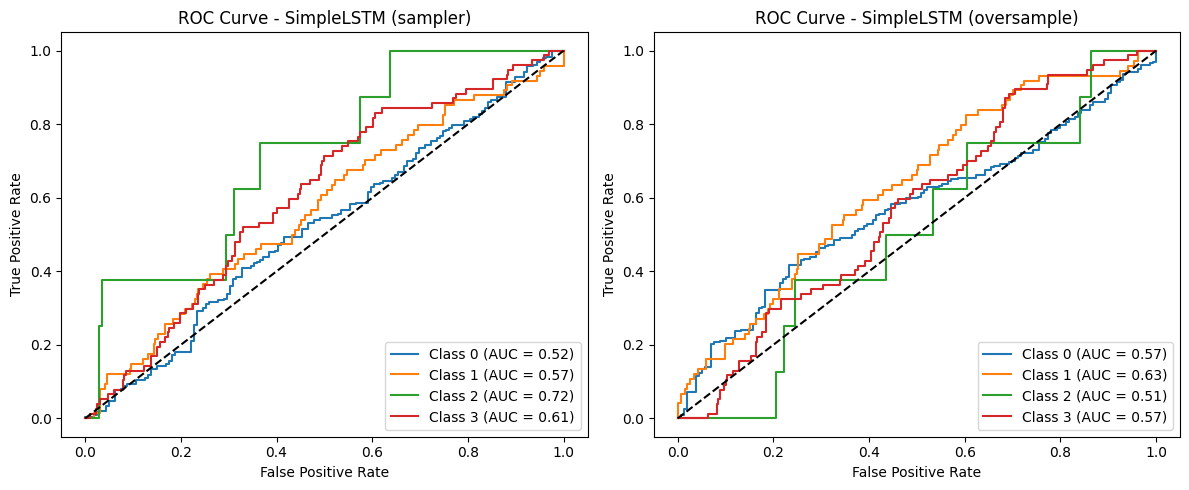

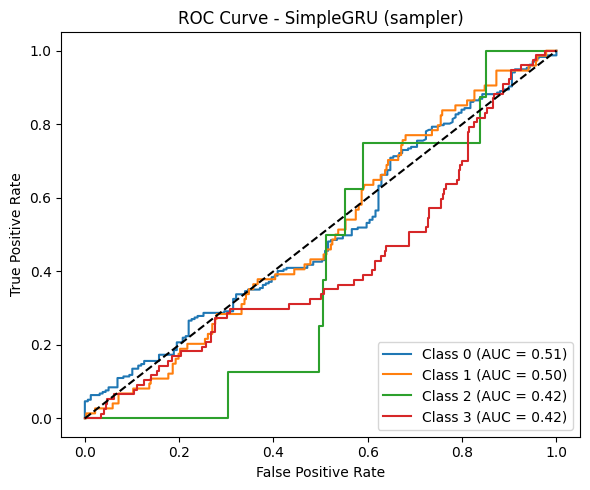

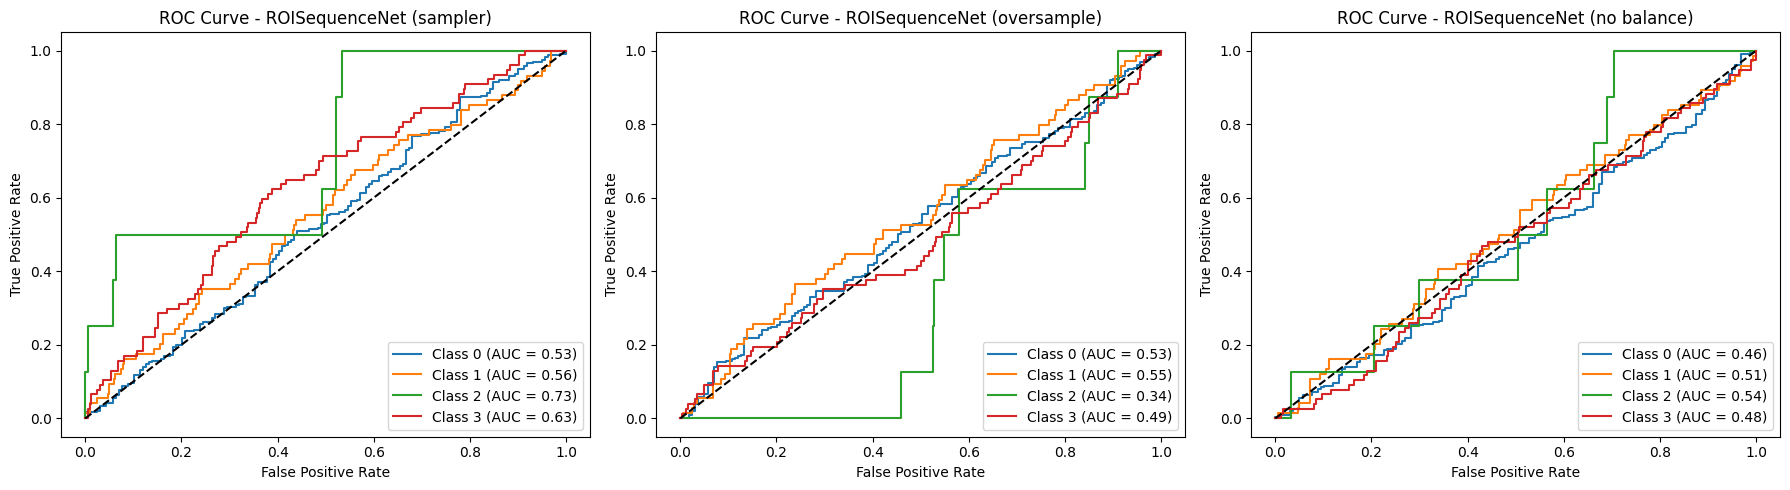

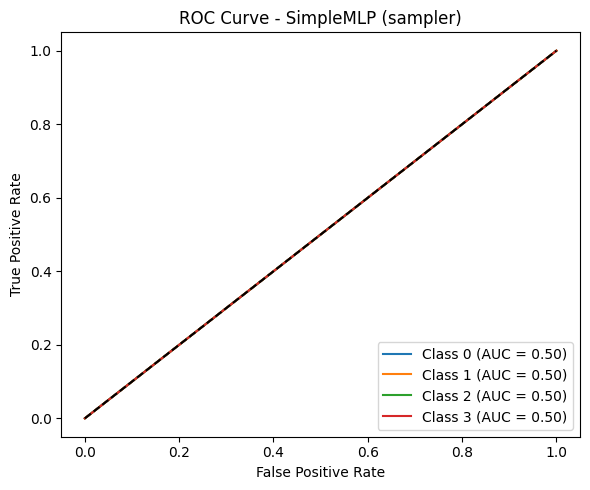


Сводная таблица финальных метрик:
                       model   val_acc   val_auc    val_f1
0         SimpleLSTM_sampler  0.414141  0.603018  0.430077
1      SimpleLSTM_oversample  0.479798  0.569941  0.468213
2          SimpleGRU_sampler  0.272727  0.460871  0.292268
3     ROISequenceNet_sampler  0.414141  0.609034  0.432463
4  ROISequenceNet_oversample  0.449495  0.477971  0.453038
5   ROISequenceNet_nobalance  0.500000  0.498558  0.427223
6          SimpleMLP_sampler  0.194444  0.500000  0.063307

[INFO] Завершено: построение ROC (если было возможно), метрики, сохранение историй.


In [235]:
# === ROC Curves и сводные метрики (устойчиво к отсутствию oversample / других моделей) ===
from sklearn.preprocessing import label_binarize
try:
    roc_curve
except NameError:
    from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, f1_score
try:
    F
except NameError:
    import torch.nn.functional as F
import os

@torch.no_grad()
def collect_probs_and_labels(model, val_loader, device):
    model.eval(); all_probs=[]; all_labels=[]
    for batch in val_loader:
        if len(batch)==5: X,M,C,y,_ = batch
        elif len(batch)==4: X,M,C,y = batch
        elif len(batch)==3: X,C,y = batch; M=None
        else: raise ValueError("Unexpected batch format")
        X=X.to(device)
        M = M.to(device) if M is not None else None
        C = C.to(device) if (C is not None and C.nelement()>0) else None
        # Унификация вызова
        if M is None and C is None:
            out = model(X)
        else:
            # поддержка аргумента z vs cov
            try:
                out = model(X, mask=M, cov=C)
            except TypeError:
                out = model(X, mask=M, z=C)
        probs = F.softmax(out, dim=1).cpu().numpy()
        all_probs.append(probs); all_labels.extend(y.numpy())
    if not all_probs:
        return np.zeros((0, N_CLASSES)), np.zeros((0,), dtype=int)
    return np.vstack(all_probs), np.array(all_labels)

classes_sorted = sorted(class_counts_main.index.tolist())
print('Classes:', classes_sorted)

# --- Сбор вероятностей (только для существующих моделей) ---
lstm_sampler_probs, lstm_sampler_labels = (None, None)
if 'model_lstm_sampler' in globals() and model_lstm_sampler is not None and 'val_dl_sampler' in globals() and val_dl_sampler is not None:
    lstm_sampler_probs, lstm_sampler_labels = collect_probs_and_labels(model_lstm_sampler, val_dl_sampler, DEVICE)

lstm_over_probs, lstm_over_labels = (None, None)
if 'model_lstm_over' in globals() and model_lstm_over is not None and 'val_dl_over' in globals() and val_dl_over is not None:
    lstm_over_probs, lstm_over_labels = collect_probs_and_labels(model_lstm_over, val_dl_over, DEVICE)

gru_sampler_probs, gru_sampler_labels = (None, None)
if 'model_gru_sampler' in globals() and model_gru_sampler is not None and 'val_dl_sampler' in globals() and val_dl_sampler is not None:
    gru_sampler_probs, gru_sampler_labels = collect_probs_and_labels(model_gru_sampler, val_dl_sampler, DEVICE)

roi_sampler_probs, roi_sampler_labels = (None, None)
if 'model_roi_seq_net_sampler' in globals() and model_roi_seq_net_sampler is not None and 'val_dl_sampler' in globals() and val_dl_sampler is not None:
    roi_sampler_probs, roi_sampler_labels = collect_probs_and_labels(model_roi_seq_net_sampler, val_dl_sampler, DEVICE)

roi_over_probs, roi_over_labels = (None, None)
if 'model_roi_seq_net_over' in globals() and model_roi_seq_net_over is not None and 'val_dl_over' in globals() and val_dl_over is not None:
    roi_over_probs, roi_over_labels = collect_probs_and_labels(model_roi_seq_net_over, val_dl_over, DEVICE)

roi_nb_probs, roi_nb_labels = (None, None)
if 'model_roi_seq_net_nb' in globals() and model_roi_seq_net_nb is not None and 'val_dl' in globals() and val_dl is not None:
    roi_nb_probs, roi_nb_labels = collect_probs_and_labels(model_roi_seq_net_nb, val_dl, DEVICE)

mlp_sampler_probs, mlp_sampler_labels = (None, None)
if 'mlp_model' in globals() and mlp_model is not None and 'val_dl_dfc_sampler' in globals() and val_dl_dfc_sampler is not None:
    mlp_sampler_probs, mlp_sampler_labels = collect_probs_and_labels(mlp_model, val_dl_dfc_sampler, DEVICE)

# --- Binarization helper (skip if probs is None) ---
def binarize(labels):
    if labels is None: return None
    return label_binarize(labels, classes=classes_sorted)

lstm_sampler_bin = binarize(lstm_sampler_labels)
lstm_over_bin    = binarize(lstm_over_labels)
gru_sampler_bin  = binarize(gru_sampler_labels)
roi_sampler_bin  = binarize(roi_sampler_labels)
roi_over_bin     = binarize(roi_over_labels)
roi_nb_bin       = binarize(roi_nb_labels)
mlp_sampler_bin  = binarize(mlp_sampler_labels)

# --- Подготовка списка для построения ROC ---
plot_categories = dict()
plot_items_lstm = []
plot_items_gru = []
plot_items_roi = []
plot_items_mlp = []
if lstm_sampler_bin is not None:
    plot_items_lstm.append(('SimpleLSTM (sampler)', lstm_sampler_bin, lstm_sampler_probs))
if lstm_over_bin is not None:
    plot_items_lstm.append(('SimpleLSTM (oversample)', lstm_over_bin, lstm_over_probs))
if gru_sampler_bin is not None:
    plot_items_gru.append(('SimpleGRU (sampler)', gru_sampler_bin, gru_sampler_probs))
if roi_sampler_bin is not None:
    plot_items_roi.append(('ROISequenceNet (sampler)', roi_sampler_bin, roi_sampler_probs))
if roi_over_bin is not None:
    plot_items_roi.append(('ROISequenceNet (oversample)', roi_over_bin, roi_over_probs))
if roi_nb_bin is not None:
    plot_items_roi.append(('ROISequenceNet (no balance)', roi_nb_bin, roi_nb_probs))
if mlp_sampler_bin is not None:
    plot_items_mlp.append(('SimpleMLP (sampler)', mlp_sampler_bin, mlp_sampler_probs))

plot_categories['LSTM Models'] = plot_items_lstm
plot_categories['GRU Models'] = plot_items_gru
plot_categories['ROISequenceNet Models'] = plot_items_roi
plot_categories['MLP Models'] = plot_items_mlp

# --- Построение ROC кривых для каждой категории моделей ---
for category, plot_items in plot_categories.items():
    if plot_items:
        fig, axes = plt.subplots(1, len(plot_items), figsize=(6*len(plot_items), 5))
        if len(plot_items) == 1:
            axes = [axes]
        for ax, (title, y_bin, probs) in zip(axes, plot_items):
            for i in range(y_bin.shape[1]):
                fpr, tpr, _ = roc_curve(y_bin[:, i], probs[:, i])
                auc_score = roc_auc_score(y_bin[:, i], probs[:, i])
                ax.plot(fpr, tpr, label=f'Class {classes_sorted[i]} (AUC = {auc_score:.2f})')
            ax.plot([0, 1], [0, 1], 'k--')
            ax.set_title(f'ROC Curve - {title}')
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.legend(loc='lower right')
        plt.tight_layout()
        plt.show()

# --- Сводная таблица метрик ---
summary_rows = []

def add_summary(name, probs, labels):
    if probs is None or labels is None:
        return
    try:
        preds = probs.argmax(1)
        acc = accuracy_score(labels, preds)
        try:
            auc = roc_auc_score(labels, probs, multi_class='ovr')
        except Exception:
            auc = float('nan')
        f1 = f1_score(labels, preds, average='weighted')
        summary_rows.append({'model': name, 'val_acc': acc, 'val_auc': auc, 'val_f1': f1})
    except Exception as e:
        print(f"[WARN] Summary failed for {name}: {e}")

add_summary('SimpleLSTM_sampler', lstm_sampler_probs, lstm_sampler_labels)
add_summary('SimpleLSTM_oversample', lstm_over_probs, lstm_over_labels)
add_summary('SimpleGRU_sampler', gru_sampler_probs, gru_sampler_labels)
add_summary('ROISequenceNet_sampler', roi_sampler_probs, roi_sampler_labels)
add_summary('ROISequenceNet_oversample', roi_over_probs, roi_over_labels)
add_summary('ROISequenceNet_nobalance', roi_nb_probs, roi_nb_labels)
add_summary('SimpleMLP_sampler', mlp_sampler_probs, mlp_sampler_labels)

summary_df = pd.DataFrame(summary_rows)
print('\nСводная таблица финальных метрик:')
print(summary_df if not summary_df.empty else '[EMPTY]')

# --- Сохранение историй (проверка наличия) ---
if 'hist_lstm_sampler_df' in globals():
    hist_lstm_sampler_df.to_csv(os.path.join(checkpoint_dir_path_lstm, 'history_lstm_sampler.csv'), index=False)
if 'hist_lstm_oversample_df' in globals() and hist_lstm_oversample_df is not None:
    hist_lstm_oversample_df.to_csv(os.path.join(checkpoint_dir_path_lstm_over, 'history_lstm_oversample.csv'), index=False)
if 'hist_gru_sampler_df' in globals():
    hist_gru_sampler_df.to_csv(os.path.join(checkpoint_dir_path_gru_sampler, 'history_gru_sampler.csv'), index=False)
if 'hist_roi_seq_sampler_df' in globals():
    hist_roi_seq_sampler_df.to_csv(os.path.join(checkpoint_dir_path_roi_seq_net_sampler, 'history_roi_seq_sampler.csv'), index=False)
if 'hist_roi_seq_oversample_df' in globals():
    hist_roi_seq_oversample_df.to_csv(os.path.join(checkpoint_dir_path_roi_seq_net_over, 'history_roi_seq_oversample.csv'), index=False)
if 'hist_roi_seq_nobalance_df' in globals():
    hist_roi_seq_nobalance_df.to_csv(os.path.join(checkpoint_dir_path_roi_seq_net_nb, 'history_roi_seq_nobalance.csv'), index=False)
if 'hist_mlp_df_sampler' in globals():
    hist_mlp_df_sampler.to_csv(os.path.join(checkpoint_dir_path_mlp, 'history_mlp_sampler.csv'), index=False)

print('\n[INFO] Завершено: построение ROC (если было возможно), метрики, сохранение историй.')

## 9) Baseline A — Статический функциональный коннектом (FC) + логистическая регрессия
Идея: из каждого временного ряда NPY `(T,R)` считаем корреляционную матрицу `R×R` (Пирсон), применяем Z **Фишера** и векторизуем верхний треугольник. Т.о. получаем признак фиксированной длины. 

Затем обучаем **LogisticRegression (multinomial)**, опционально предваряя **PCA** до `FC_PCA_COMPONENTS`.

Разбиение — то же групповое (без утечек).

In [232]:
idx = np.arange(len(data_df))
gss = GroupShuffleSplit(n_splits=1, test_size=VAL_SIZE, random_state=SEED)
train_idx, val_idx = next(gss.split(idx, groups=data_df['site_x'].values))
train_df, val_df = data_df.iloc[train_idx].reset_index(drop=True), data_df.iloc[val_idx].reset_index(drop=True)

print(f"train N={len(train_df)}, val N={len(val_df)}; groups → train:{train_df['site_x'].nunique()}, val:{val_df['site_x'].nunique()}")

train N=1438, val N=483; groups → train:7, val:2


In [233]:
if RUN_BASELINES:
    def fisher_z(r):
        r = np.clip(r, -0.999999, 0.999999)
        return 0.5 * np.log((1+r)/(1-r))

    def vec_uppertri(M):
        iu = np.triu_indices_from(M, k=1)
        return M[iu]

    def fc_vector_from_npy(path):
        X = np.load(path)  # (T,R)
        C = np.corrcoef(X, rowvar=False)
        # Replace NaNs arising from zero-variance ROI time series
        C = np.nan_to_num(C, nan=0.0, posinf=0.0, neginf=0.0)
        np.fill_diagonal(C, 1.0)
        Cz = fisher_z(C)
        return vec_uppertri(Cz)

    def build_fc_matrix(df):
        feats = [fc_vector_from_npy(p) for p in df['npy_path']]
        X = np.vstack(feats)
        # Safety: ensure no NaNs remain
        X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
        y = df['label'].values.astype(int)
        return X, y

    Xtr, ytr = build_fc_matrix(train_df)
    Xva, yva = build_fc_matrix(val_df)
    scaler = StandardScaler(with_mean=True, with_std=True)
    Xtr_s = scaler.fit_transform(Xtr)
    Xva_s = scaler.transform(Xva)
    # Extra safety before PCA
    if np.isnan(Xtr_s).any() or np.isnan(Xva_s).any():
        Xtr_s = np.nan_to_num(Xtr_s, nan=0.0, posinf=0.0, neginf=0.0)
        Xva_s = np.nan_to_num(Xva_s, nan=0.0, posinf=0.0, neginf=0.0)
    
    if FC_PCA_COMPONENTS and FC_PCA_COMPONENTS > 0:
        # PCA ограничение: n_components <= min(n_samples, n_features)
        allowable = min(Xtr_s.shape[0], Xtr_s.shape[1])
        n_comp = min(FC_PCA_COMPONENTS, allowable)
        if n_comp < 1:
            print("Пропуск PCA: недостаточно допустимых компонент.")
        else:
            if n_comp != FC_PCA_COMPONENTS:
                print(f"Понижено число компонент PCA с {FC_PCA_COMPONENTS} до {n_comp} (min(n_samples={Xtr_s.shape[0]}, n_features={Xtr_s.shape[1]})).")
            pca = PCA(n_components=n_comp)
            Xtr_s = pca.fit_transform(Xtr_s)
            Xva_s = pca.transform(Xva_s)
    clf = LogisticRegression(max_iter=500, multi_class='multinomial', solver='lbfgs')
    clf.fit(Xtr_s, ytr)
    pr_tr = clf.predict_proba(Xtr_s); pr_va = clf.predict_proba(Xva_s)
    yh_va = pr_va.argmax(1)
    acc = accuracy_score(yva, yh_va)
    f1  = f1_score(yva, yh_va, average='macro')
    try:
        auc = roc_auc_score(yva, pr_va, multi_class='ovr', average='macro')
    except Exception:
        auc = float('nan')
    print(f"[FC-LogReg] val_acc={acc:.3f} | val_auc={auc:.3f} | val_f1={f1:.3f}")


[FC-LogReg] val_acc=0.462 | val_auc=0.513 | val_f1=0.244


## 10) Baseline B — Динамический FC + HMM-фичи (или KMeans fallback)
Идея: скользящим окном (`WIN_DYN`, шаг `STEP_DYN`) считаем FC по каждому окну → получаем последовательность векторов ("кадров") на субъекта. 
На **train** обучаем `GaussianHMM(n_states=HMM_N_STATES)` по этим кадрам. Для каждого субъекта считаем признаки:
- доля времени в каждом состоянии,
- частота переключений,
- средняя длительность посещений.
Если `hmmlearn` недоступен, используем **KMeans** как приближение скрытых состояний.
Классификатор: `LogisticRegression` на агрегированных признаках.

In [ ]:
def sliding_windows(X, win=30, step=5):
    t, r = X.shape
    for s in range(0, max(1, t - win + 1), step):
        e = min(t, s + win)
        if e - s >= max(5, win//2):
            yield X[s:e]

def fc_frames_from_npy(path, win=30, step=5):
    X = np.load(path)
    frames = []
    for seg in sliding_windows(X, win, step):
        C = np.corrcoef(seg, rowvar=False)
        r = 0.5*np.log((1+np.clip(C, -0.999999, 0.999999))/(1-np.clip(C, -0.999999, 0.999999)))
        iu = np.triu_indices_from(r, k=1)
        frames.append(r[iu])
    if not frames:
        C = np.corrcoef(X, rowvar=False); iu = np.triu_indices_from(C, 1)
        r = 0.5*np.log((1+np.clip(C, -0.999999, 0.999999))/(1-np.clip(C, -0.999999, 0.999999)))
        frames = [r[iu]]
    print("DynFC train frame shapes:")
    print([f.shape for f in frames[:10]])
    return np.vstack(frames)

def summarize_states(states, n_states):
    T = len(states)
    if T == 0:
        return np.zeros(n_states + 2)
    frac = np.bincount(states, minlength=n_states) / max(1, T)
    switches = (states[1:] != states[:-1]).mean() if T>1 else 0.0
    lengths = []
    cur = 1
    for i in range(1, T):
        if states[i]==states[i-1]: cur += 1
        else: lengths.append(cur); cur = 1
    lengths.append(cur)
    dwell = float(np.mean(lengths))
    return np.concatenate([frac, [switches, dwell]])

def pad_or_truncate_frames_list(fr_list, target_dim):
    fixed = []
    for fr in fr_list:
        cur_dim = fr.shape[1]
        if cur_dim < target_dim:
            pad = np.zeros((fr.shape[0], target_dim - cur_dim), dtype=fr.dtype)
            fr = np.hstack([fr, pad])
        elif cur_dim > target_dim:
            fr = fr[:, :target_dim]
        fixed.append(fr)
    return fixed

In [ ]:
if RUN_BASELINES:    
    # Получаем кадры динамического FC
    tr_frames = [fc_frames_from_npy(p, WIN_DYN, STEP_DYN) for p in train_df['npy_path']]
    va_frames = [fc_frames_from_npy(p, WIN_DYN, STEP_DYN) for p in val_df['npy_path']]

    # Санитизация (NaN / inf -> 0)
    def sanitize_frames(fr_list):
        return [np.nan_to_num(f, nan=0.0, posinf=0.0, neginf=0.0) for f in fr_list]

    tr_frames = sanitize_frames(tr_frames)
    va_frames = sanitize_frames(va_frames)

    # Выравнивание размерности кадров перед vstack
    max_dim = max(fr.shape[1] for fr in tr_frames + va_frames)

    tr_frames = pad_or_truncate_frames_list(tr_frames, max_dim)
    va_frames = pad_or_truncate_frames_list(va_frames, max_dim)

    # Объединяем обучающие кадры
    Xtrain_seq = np.vstack(tr_frames)
    Xtrain_seq = np.nan_to_num(Xtrain_seq, nan=0.0, posinf=0.0, neginf=0.0)

    # Удаляем/обрабатываем почти константные признаки (иначе ковариации будут нулевые, что сломает HMM)
    var = Xtrain_seq.var(axis=0)
    dyn_keep_cols = var > 1e-12
    if dyn_keep_cols.sum() < Xtrain_seq.shape[1]:
        removed = (~dyn_keep_cols).sum()
        print(f"[DynFC] Removed {removed} near-constant features before HMM/KMeans.")
        Xtrain_seq = Xtrain_seq[:, dyn_keep_cols]
    else:
        dyn_keep_cols = None  # ничего не удаляем

In [ ]:
if RUN_BASELINES:
    # HAS_HMM флаг (модуль уже импортирован выше, просто оставим структуру)
    HAS_HMM = True  # По-умолчанию используем Hidden Markov Model

    def _apply_keep(frames):
        """
        Санитизация + приведение числа признаков к размеру dyn_keep_cols.
        Исправление IndexError при несовпадении длины boolean mask и числа колонок:
        - Если во входном кадре меньше признаков (из-за различного числа ROI после salvage),
            дополняем нулями.
        - Если больше — обрезаем.
        После выравнивания применяем dyn_keep_cols.
        """
        frames = np.nan_to_num(frames, nan=0.0, posinf=0.0, neginf=0.0)
        if dyn_keep_cols is not None:
            target_len = dyn_keep_cols.shape[0]
            cur_len = frames.shape[1]
            if cur_len != target_len:
                if cur_len < target_len:
                    # pad zeros to the right
                    pad = np.zeros((frames.shape[0], target_len - cur_len), dtype=frames.dtype)
                    frames = np.hstack([frames, pad])
                else:
                    # truncate extra columns
                    frames = frames[:, :target_len]
            # now safe to index
            frames = frames[:, dyn_keep_cols]
        return frames

    # Лёгкая стабилизация: добавим eps к абсолютно нулевым столбцам (если остались)
    zero_var_cols = (Xtrain_seq.var(axis=0) <= 1e-12)
    if zero_var_cols.any():
        Xtrain_seq[:, zero_var_cols] += np.random.randn(Xtrain_seq.shape[0], zero_var_cols.sum()) * 1e-6
        print(f"[DynFC] Injected epsilon noise into {zero_var_cols.sum()} zero-variance columns.")

    n_states = int(HMM_N_STATES)

    if HAS_HMM:
        model_states = GaussianHMM(n_components=n_states, covariance_type='diag', n_iter=200, random_state=0)
        try:
            model_states.fit(Xtrain_seq)
        except ValueError as e:
            print(f"[DynFC-HMM] HMM fit failed ({e}) -> fallback to KMeans.")
            HAS_HMM = False

    if HAS_HMM:
        def assign_states(frames):
            frames = _apply_keep(frames)
            return model_states.predict(frames)
    else:
        # Fallback: KMeans
        kmeans = KMeans(n_clusters=n_states, random_state=0)
        kmeans.fit(Xtrain_seq)

        def assign_states(frames):
            frames = _apply_keep(frames)
            return kmeans.predict(frames)

: 

In [ ]:
if RUN_BASELINES:
    def build_dyn_feats(frames_list):
        feats = []
        for fr in frames_list:
            fr_san = _apply_keep(fr)
            st = assign_states(fr_san)
            feats.append(summarize_states(st, n_states))
        return np.vstack(feats)

    # Строим агрегированные признаки состояний
    Xtr = build_dyn_feats(tr_frames)
    ytr = train_df['label'].values.astype(int)
    Xva = build_dyn_feats(va_frames)
    yva = val_df['label'].values.astype(int)

    # Финальная модель
    clf = LogisticRegression(max_iter=500, multi_class='multinomial', solver='lbfgs')
    clf.fit(Xtr, ytr)

    pr_va = clf.predict_proba(Xva)
    yh_va = pr_va.argmax(1)
    acc = accuracy_score(yva, yh_va)
    f1 = f1_score(yva, yh_va, average='macro')
    try:
        auc = roc_auc_score(yva, pr_va, multi_class='ovr', average='macro')
    except Exception:
        auc = float('nan')
    print(f"[DynFC-HMM] val_acc={acc:.3f} | val_auc={auc:.3f} | val_f1={f1:.3f} | HAS_HMM={HAS_HMM}")


[DynFC-HMM] val_acc=0.523 | val_auc=nan | val_f1=0.172 | HAS_HMM=False


## 11) Оценка переносимости: Leave-One-Site-Out (LOSO) для FC-baseline
Для каждого сайта извлекаем его как **валидационную** выборку, обучаемся на остальных и считаем метрики. Это имитирует перенос на новый центр/сканер.

In [ ]:
def fisher_z(r):
    r = np.clip(r, -0.999999, 0.999999)
    return 0.5*np.log((1+r)/(1-r))

def vec_uppertri(M):
    iu = np.triu_indices_from(M, k=1)
    return M[iu]

def fc_vector_from_npy(path):
    X = np.load(path)
    C = np.corrcoef(X, rowvar=False)
    Cz = fisher_z(C)
    return vec_uppertri(Cz)

def build_fc_matrix(df):
    feats = [fc_vector_from_npy(p) for p in df['npy_path']]
    X = np.vstack(feats)
    y = df['label'].values.astype(int)
    return X, y

def pid2site(pid):
    s = pid.replace('sub-','')
    m = re.match(r'([a-z]+)', s)
    return m.group(1) if m else 'na'

In [ ]:
if RUN_BASELINES and DO_LOSO:
    sites = sorted({pid2site(pid) for pid in data_df['participant_id']})
    res = []
    for site in sites:
        tr_idx = data_df['participant_id'].map(pid2site) != site
        va_idx = ~tr_idx
        tr_df = data_df[tr_idx].reset_index(drop=True)
        va_df = data_df[va_idx].reset_index(drop=True)
        if len(va_df) < 5 or len(tr_df) < 10:
            print(f"[LOSO:{site}] слишком мало данных — пропуск")
            continue
        # Формирование признаков (могут содержать NaN из-за нулевой дисперсии ROI)
        Xtr, ytr = build_fc_matrix(tr_df)
        Xva, yva = build_fc_matrix(va_df)
        # Заменяем NaN / inf значениями 0 перед любыми трансформациями
        Xtr = np.nan_to_num(Xtr, nan=0.0, posinf=0.0, neginf=0.0)
        Xva = np.nan_to_num(Xva, nan=0.0, posinf=0.0, neginf=0.0)
        # Масштабирование
        scaler = StandardScaler()
        Xtr_s = scaler.fit_transform(Xtr)
        Xva_s = scaler.transform(Xva)
        # Повторная санитаризация (иногда стандартизация может породить inf при нулевом std)
        Xtr_s = np.nan_to_num(Xtr_s, nan=0.0, posinf=0.0, neginf=0.0)
        Xva_s = np.nan_to_num(Xva_s, nan=0.0, posinf=0.0, neginf=0.0)
        # PCA (с проверкой допустимого числа компонент и отсутствия NaN)
        if FC_PCA_COMPONENTS and FC_PCA_COMPONENTS > 0:
            allowable = min(Xtr_s.shape[0], Xtr_s.shape[1])
            n_comp = min(FC_PCA_COMPONENTS, allowable)
            if n_comp < 1:
                print(f"[LOSO:{site}] Пропуск PCA (недостаточно компонент).")
            else:
                if n_comp != FC_PCA_COMPONENTS:
                    print(f"[LOSO:{site}] PCA компонентов снижено до {n_comp} (allowable={allowable}).")
                # Санитизация перед PCA fit
                Xtr_s = np.nan_to_num(Xtr_s, nan=0.0, posinf=0.0, neginf=0.0)
                Xva_s = np.nan_to_num(Xva_s, nan=0.0, posinf=0.0, neginf=0.0)
                try:
                    pca = PCA(n_components=n_comp)
                    Xtr_s = pca.fit_transform(Xtr_s)
                    Xva_s = pca.transform(Xva_s)
                    # Финальная санитаризация
                    Xtr_s = np.nan_to_num(Xtr_s, nan=0.0, posinf=0.0, neginf=0.0)
                    Xva_s = np.nan_to_num(Xva_s, nan=0.0, posinf=0.0, neginf=0.0)
                except ValueError as e:
                    print(f"[LOSO:{site}] Пропуск PCA из-за ошибки: {e}")
        # Обучение логистической регрессии
        clf = LogisticRegression(max_iter=500, multi_class='multinomial', solver='lbfgs')
        clf.fit(Xtr_s, ytr)
        pr = clf.predict_proba(Xva_s); yh = pr.argmax(1)
        acc = accuracy_score(yva, yh)
        f1  = f1_score(yva, yh, average='macro')
        try:
            auc = roc_auc_score(yva, pr, multi_class='ovr', average='macro')
        except Exception:
            auc = float('nan')
        res.append({"site": site, "N_val": len(va_df), "acc":acc, "auc":auc, "f1":f1})
        print(f"[LOSO:{site}] N={len(va_df)} | acc={acc:.3f} | auc={auc:.3f} | f1={f1:.3f}")
    if res:
        df_res = pd.DataFrame(res)
        display(df_res)
        print("Средние по сайтам:", df_res[['acc','auc','f1']].mean().to_dict())


[LOSO:kki] N=9 | acc=0.556 | auc=nan | f1=0.192
[LOSO:neuroimage] N=56 | acc=0.554 | auc=0.684 | f1=0.317
[LOSO:nyu] N=127 | acc=0.520 | auc=nan | f1=0.207
[LOSO:peking] N=92 | acc=0.696 | auc=nan | f1=0.492
[LOSO:pittsburgh] N=36 | acc=0.750 | auc=nan | f1=0.286
[LOSO:washu] N=52 | acc=0.731 | auc=nan | f1=0.281


,site,N_val,acc,auc,f1
0,kki,9,0.555556,NaN,0.192308
1,neuroimage,56,0.553571,0.683831,0.317409
2,nyu,127,0.519685,NaN,0.206910
3,peking,92,0.695652,NaN,0.492492
4,pittsburgh,36,0.750000,NaN,0.285714
5,washu,52,0.730769,NaN,0.281481


Средние по сайтам: {'acc': 0.6342055713632229, 'auc': 0.6838305461073318, 'f1': 0.2960525144200667}


In [ ]:
rows = [
    ["Отбор данных","ADHD200; когорты 12–15 и 16–21; унификация ID; контроль утечки (splits по participant_id)",
     "Фенотипы (CSV), фильтры по возрасту, групповые сплиты по participant_id","Сделано"],
    ["Подготовка сигналов","ROI-тайм-серии Athena; окна фикс. длины T_FIX; mask паддинга; TR из BIDS",
     ".npy/.tsv.gz (T×R), *_mask.npy, *_bold.json","Сделано"],
    ["Базовые признаки","Статическая FC из окна (Fisher-z верхний треугольник)",
     "Внутренняя функция расчёта FC; baseline","Сделано"],
    ["Ковариаты","Age / Gender / Site (предобработка и добавление в модель)",
     "ColumnTransformer: StandardScaler + OneHotEncoder (fit на train)","Сделано"],
    ["Модели (последоват.)","LSTM, GRU на (T, R) с поддержкой mask (зануление/pack)",
     "PyTorch DataLoader (B, T, R)","Сделано"],
    ["Основная модель","ROISequenceNet: Conv1d по времени per-ROI + Self-Attention по ROI + классификация",
     "PyTorch; вход (T, R); mask учитывается","Сделано"],
    ["Бейзлайн (классика)","LogisticRegression на статической FC","scikit-learn","Сделано"],
    ["Валидация и метрики","StratifiedGroupKFold / GroupShuffleSplit по participant_id; Accuracy/Precision/F1/AUC",
     "sklearn.metrics; логирование результатов","Сделано (нестабильность из-за объёма)"],
    ["Гармонизация по сайту","Коррекция межсайтовых сдвигов (ComBat)","neuroComBat/аналог","План"],
    ["Motion-QC","FD/DVARS как ковариаты/фильтр; скраббинг","Конфаунды из fMRIPrep/Athena","План"],
    ["dFC-признаки","Окна → FC-векторы → k-means состояния → occupancy/transition/dwell",
     "DFC_CSV + MLP/ROISequenceNet","План"],
    ["Последовательность окон","TCN/Transformer «по окнам» (моделирование переходов состояний)",
     "PyTorch (вторая ось времени: окно→окно)","План"],
    ["Интерпретация","Пермутационные важности, Integrated Gradients, карты внимания",
     "Captum/собственные процедуры","План"],
    ["Воспроизводимость","2 ноутбука: (1) подготовка/QC, (2) обучение/оценка; фиксация seed/версий",
     "Версионирование манифеста/парцелляций/конфигов","Сделано"],
]

df = pd.DataFrame(rows, columns=["Этап","Метод / данные","Инструменты и артефакты","Статус"])

out_xls  = Path("methodology_ADHD200.xls")
out_xlsx = Path("methodology_ADHD200.xlsx")
out_csv  = Path("methodology_ADHD200.csv")

# Удаляем старые файлы, если есть
for f in [out_xls, out_xlsx, out_csv]:
    if f.exists():
        f.unlink()

saved = None
try:
    df.to_excel(out_xls, index=False)      # требует пакет xlwt для .xls
    saved = out_xls
except Exception:
    df.to_excel(out_xlsx, index=False)     # универсальный .xlsx (требует openpyxl)
    saved = out_xlsx

df.to_csv(out_csv, index=False)

print("Saved Excel to:", saved.resolve())
print("Also CSV:", out_csv.resolve())

python(87571) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Note: you may need to restart the kernel to use updated packages.


python(87635) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]1/2 [openpyxl]
Note: you may need to restart the kernel to use updated packages.
Saved Excel to: /Users/alexey.stafeev/Documents/!Documents/Магистратура_МФТИ/Предметы/НИР/Материалы/ADHD200/Athena/methodology_ADHD200.xls
Also CSV: /Users/alexey.stafeev/Documents/!Documents/Магистратура_МФТИ/Предметы/НИР/Материалы/ADHD200/Athena/methodology_ADHD200.csv
